# Testing conditional valid metrics for locart in new simulated settings and with new models

Here we will test conformal methods in different data settings and models to analyse why locart is having a worse perfomance than the other conformal methods in real data

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st

# base models and graph tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# conformal methods
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from lcv.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, QuantileSplit
from lcv.locart import LocartSplit, MondrianRegressionSplit
from lcv.locluster import KmeansSplit
from lcv.scores import RegressionScore, QuantileScore, LocalRegressionScore

# importing LCP-RF
from acpi import ACPI

# simulation and performance measures
import time
from lcv.simulation import simulation
from lcv.utils import compute_interval_length, ILS_coverage, split, real_coverage, smis, wsc_coverage, pearson_correlation, HSIC_correlation
from lcv.valid_pred_sets import Valid_pred_sets

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Default testing metrics function:

In [2]:
def testing_metrics_sim(
    n = 25000,
    kind = "homoscedastic",
    d = 20,
    hetero_value = 1,
    asym_value = 0.6,
    t_degree = 4,
    base_model = RandomForestRegressor, 
    sig = 0.1, 
    test_size = 0.2,
    valid_test_size = 0.2,
    valid_split = True,
    valid_min_sample = 100,
    valid_prune = True,
    calib_size = 0.5, 
    coef = 2,
    noise = True,
    signif_vars = 5,
    B_x = 5000,
    B_y = 1000, 
    random_seed_X = 850,
    random_seed = 1250,
    random_projections = False,
    h = 20,
    m = 300,
    split_calib = True,
    plot_tree = True,
    plot_weighted_tree = True,
    mad_model_cte = False,
    nbins = 10,
    criterion = "squared_error",
    max_depth = None,
    max_leaf_nodes = None,
    min_samples_leaf = 150,
    prune = True,
    **kwargs):
    # generating X_test
    np.random.seed(random_seed_X)

    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, noise = noise, signif_vars = signif_vars, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    data = split(sim_obj.X, sim_obj.y, test_size = test_size, calib_size = calib_size, calibrate = True, random_seed = random_seed)
    r_kind = getattr(sim_obj, kind + "_r")
    if noise:
        y_mat = r_kind(X_test[:, 0], B = B_y)
    else:
        y_mat = r_kind(X_test, B = B_y)
        

    # fitting normal locart
    print("Fitting deafult locart to toy example:")
    start_loc = time.time()
    locart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "CART", base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    locart_pred = np.array(locart_obj.predict(data["X_test"]))
    locart_pred_cond = np.array(locart_obj.predict(X_test))
    cond_locart_real = real_coverage(locart_pred_cond, y_mat)

    # average, median and max distance
    dif_locart = np.abs(cond_locart_real - (1 - sig))
    locart_ave_dist, locart_med_dist, locart_max_dist = np.mean(dif_locart), np.median(dif_locart), np.max(dif_locart)

    locart_pcor = pearson_correlation(locart_pred, data["y_test"])
    locart_hsic = HSIC_correlation(locart_pred, data["y_test"])


    # valid pred sets
    locart_valid = Valid_pred_sets(conf = locart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    locart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_loc, max_set_dif_loc = locart_valid.compute_dif()

    # smis
    locart_smis = smis(locart_pred, data["y_test"], alpha = sig)

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= locart_pred[:, 0], 
        data["y_test"] <= locart_pred[:, 1]) + 0
    locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)

    # fitting normal RF-locart
    print("Fitting deafult RF-locart to toy example:")
    start_loc = time.time()
    rf_locart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "RF", base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    rf_locart_obj.fit(data["X_train"], data["y_train"])
    rf_locart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit RF-Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    rf_locart_pred = np.array(rf_locart_obj.predict(data["X_test"]))
    rf_locart_pred_cond = np.array(rf_locart_obj.predict(X_test))
    cond_rf_locart_real = real_coverage(rf_locart_pred_cond, y_mat)

    # average, median and max distance
    dif_rf_locart = np.abs(cond_rf_locart_real - (1 - sig))
    rf_locart_ave_dist, rf_locart_med_dist, rf_locart_max_dist = np.mean(dif_rf_locart), np.median(dif_rf_locart), np.max(dif_rf_locart)


    # valid pred sets
    rf_locart_valid = Valid_pred_sets(conf = rf_locart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    rf_locart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_rf_loc, max_set_dif_rf_loc = rf_locart_valid.compute_dif()

    # smis
    rf_locart_smis = smis(rf_locart_pred, data["y_test"], alpha = sig)

    # mean interval length
    rf_locart_interval_len = np.mean(compute_interval_length(rf_locart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= rf_locart_pred[:, 0], 
        data["y_test"] <= rf_locart_pred[:, 1]) + 0
    rf_locart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    rf_locart_interval_len_cover = np.mean(compute_interval_length(rf_locart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for RF-Locart: ", end_loc)


    # fitting normal difficulty locart
    print("Fitting difficulty locart to toy example:")
    start_loc = time.time()
    dlocart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "CART", base_model = base_model, alpha = sig, split_calib = split_calib, 
                              weighting = True,**kwargs)
    dlocart_obj.fit(data["X_train"], data["y_train"])
    dlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    dlocart_pred = np.array(dlocart_obj.predict(data["X_test"]))
    dlocart_pred_cond = np.array(dlocart_obj.predict(X_test))
    cond_dlocart_real = real_coverage(dlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_dlocart = np.abs(cond_dlocart_real - (1 - sig))
    dlocart_ave_dist, dlocart_med_dist, dlocart_max_dist = np.mean(dif_dlocart), np.median(dif_dlocart), np.max(dif_dlocart)


    # valid pred sets
    dlocart_valid = Valid_pred_sets(conf = dlocart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    dlocart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_dloc, max_set_dif_dloc = dlocart_valid.compute_dif()

    # smis
    dlocart_smis = smis(dlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    dlocart_interval_len = np.mean(compute_interval_length(dlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= dlocart_pred[:, 0], 
        data["y_test"] <= dlocart_pred[:, 1]) + 0
    dlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    dlocart_interval_len_cover = np.mean(compute_interval_length(dlocart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    # fitting RF difficulty locart
    print("Fitting difficulty RF-locart to toy example:")
    start_loc = time.time()
    rf_dlocart_obj = LocartSplit(nc_score = RegressionScore, cart_type = "RF", base_model = base_model, alpha = sig, split_calib = split_calib, weighting = True, **kwargs)
    rf_dlocart_obj.fit(data["X_train"], data["y_train"])
    rf_dlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune, random_projections = random_projections, 
    m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    rf_dlocart_pred = np.array(rf_dlocart_obj.predict(data["X_test"]))
    rf_dlocart_pred_cond = np.array(rf_dlocart_obj.predict(X_test))
    cond_rf_dlocart_real = real_coverage(rf_dlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_rf_dlocart = np.abs(cond_rf_dlocart_real - (1 - sig))
    rf_dlocart_ave_dist, rf_dlocart_med_dist, rf_dlocart_max_dist = np.mean(dif_rf_dlocart), np.median(dif_rf_dlocart), np.max(dif_rf_dlocart)


    # valid pred sets
    rf_dlocart_valid = Valid_pred_sets(conf = rf_dlocart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    rf_dlocart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_rf_dloc, max_set_dif_rf_dloc = rf_dlocart_valid.compute_dif()

    # smis
    rf_dlocart_smis = smis(rf_dlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    rf_dlocart_interval_len = np.mean(compute_interval_length(rf_dlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= rf_dlocart_pred[:, 0], 
        data["y_test"] <= rf_dlocart_pred[:, 1]) + 0
    rf_dlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    rf_dlocart_interval_len_cover = np.mean(compute_interval_length(rf_dlocart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for RF difficulty-Locart: ", end_loc)

    # fitting ACPI/LCP-RF
    print("Fitting LCP-RF to toy example:")
    start_loc = time.time()

    model = base_model(**kwargs)
    model.fit(data["X_train"], data["y_train"])
    acpi = ACPI(model_cali = model, n_estimators = 100)
    acpi.fit(data["X_calib"], data["y_calib"], nonconformity_func = None)
    acpi.fit_calibration(data["X_calib"], data["y_calib"], quantile = 1 - sig, only_qrf = True)

    end_loc = time.time() - start_loc
    print("Time Elapsed to fit LCP-RF: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()

    acpi_pred = np.stack((acpi.predict_pi(data["X_test"], method = "qrf")), axis = -1)
    acpi_pred_cond = np.stack((acpi.predict_pi(X_test, method = "qrf")), axis = -1)
    cond_acpi_real = real_coverage(acpi_pred_cond, y_mat)

    # valid pred sets
    acpi_valid = Valid_pred_sets(conf = acpi, alpha = sig, islcp = True, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    acpi_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_acpi, max_set_dif_acpi = acpi_valid.compute_dif()

    # average, median and max distance
    dif_acpi = np.abs(cond_acpi_real - (1 - sig))
    acpi_ave_dist, acpi_med_dist, acpi_max_dist = np.mean(dif_acpi), np.median(dif_acpi), np.max(dif_acpi)

    # smis
    acpi_smis = smis(acpi_pred, data["y_test"], alpha = sig)

    # mean interval length
    acpi_interval_len = np.mean(compute_interval_length(acpi_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= acpi_pred[:, 0], 
        data["y_test"] <= acpi_pred[:, 1]) + 0
    acpi_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    acpi_interval_len_cover = np.mean(compute_interval_length(acpi_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for LCP-RF: ", end_loc)

    # fitting wlocart
    print("Fitting weighted RF-locart to toy example:")
    start_loc = time.time()

    wlocart_obj = LocartSplit(nc_score = LocalRegressionScore, cart_type = "RF", base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
    wlocart_obj.fit(data["X_train"], data["y_train"], mad_model_cte = mad_model_cte)
    wlocart_obj.calib(data["X_calib"], data["y_calib"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune,
        random_projections = random_projections, m = m, h = h)
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    # predictions
    wlocart_pred = np.array(wlocart_obj.predict(data["X_test"]))
    wlocart_pred_cond = np.array(wlocart_obj.predict(X_test))
    cond_wlocart_real = real_coverage(wlocart_pred_cond, y_mat)

    # average, median and max distance
    dif_wlocart = np.abs(cond_wlocart_real - (1 - sig))
    wlocart_ave_dist, wlocart_med_dist, wlocart_max_dist = np.mean(dif_wlocart), np.median(dif_wlocart), np.max(dif_wlocart)


    # valid pred sets
    wlocart_valid = Valid_pred_sets(conf = wlocart_obj, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    wlocart_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_wloc, max_set_dif_wloc = wlocart_valid.compute_dif()

    # smis
    wlocart_smis = smis(wlocart_pred, data["y_test"], alpha = sig)

    # mean interval length
    wlocart_interval_len = np.mean(compute_interval_length(wlocart_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wlocart_pred[:, 0], 
        data["y_test"] <= wlocart_pred[:, 1]) + 0
    wlocart_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wlocart_interval_len_cover = np.mean(compute_interval_length(wlocart_pred[cover_idx]))

    wloc_cutoffs = wlocart_obj.cutoffs

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Locart: ", end_loc)


    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    model = base_model(**kwargs)
    nc = NcFactory.create_nc(model)
    icp = IcpRegressor(nc)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_calib"], data["y_calib"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()
    # predictions
    icp_pred = icp.predict(data["X_test"], significance = sig)
    icp_pred_cond = icp.predict(X_test, significance = sig)
    cond_icp_real = real_coverage(icp_pred_cond, y_mat)
    
    # average, median and max distance
    dif_icp = np.abs(cond_icp_real - (1 - sig))
    icp_ave_dist, icp_med_dist, icp_max_dist = np.mean(dif_icp), np.median(dif_icp), np.max(dif_icp)

    # valid pred sets
    icp_valid = Valid_pred_sets(conf = icp, alpha = sig, isnc = True, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    icp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_icp, max_set_dif_icp = icp_valid.compute_dif()

    # icp smis
    icp_smis = smis(icp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= icp_pred[:, 0], 
        data["y_test"] <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(data["X_test"])
    wicp_pred_cond = wicp.predict(X_test)
    cond_wicp_real = real_coverage(wicp_pred_cond, y_mat)
    
    
    wicp_dif = np.abs(cond_wicp_real - (1 - sig))
    wicp_ave_dist, wicp_med_dist, wicp_max_dist = np.mean(wicp_dif), np.median(wicp_dif), np.max(wicp_dif)

    # valid pred sets
    wicp_valid = Valid_pred_sets(conf = wicp, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    wicp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_wicp , max_set_dif_wicp = wicp_valid.compute_dif()

    # smis
    wicp_smis = smis(wicp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= wicp_pred[:, 0], 
        data["y_test"] <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    wicp_cutoff = wicp.cutoff

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

    # mondrian split
    print("Fitting mondrian regression split")
    start_weighted_split = time.time()
    micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
    micp.fit(data["X_train"], data["y_train"])
    micp.calibrate(data["X_calib"], data["y_calib"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit mondrian regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    micp_pred = micp.predict(data["X_test"])
    micp_pred_cond = micp.predict(X_test)
    cond_micp_real = real_coverage(micp_pred_cond, y_mat)
    
    
    micp_dif = np.abs(cond_micp_real - (1 - sig))
    micp_ave_dist, micp_med_dist, micp_max_dist = np.mean(micp_dif), np.median(micp_dif), np.max(micp_dif)

    # valid pred sets
    micp_valid = Valid_pred_sets(conf = micp, alpha = sig, coverage_evaluator = "CART", prune = valid_prune, split_train = valid_split)
    micp_valid.fit(data["X_test"], data["y_test"], test_size = valid_test_size, min_samples_leaf = valid_min_sample)
    pred_set_dif_micp, max_set_dif_micp = micp_valid.compute_dif()

    # smis
    micp_smis = smis(micp_pred, data["y_test"], alpha = sig)

    # ICP interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))

    # marginal coverage
    marg_cover = np.logical_and(data["y_test"] >= micp_pred[:, 0], 
        data["y_test"] <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))


    print("Cutoff points of wlocart: {}".format(wloc_cutoffs))
    print("Cutoff point of wicp: {}".format(wicp.cutoff))


    all_results =  pd.DataFrame(data = {"Methods":["LOCART", "RF-LOCART", "D-LOCART", "RF-D-LOCART", "LCP-RF", "Weighted LOCART", 
                                                   "Regresion split", "Weighted regression split", "Mondrian regression split"],
        "valid pred set":[pred_set_dif_loc, pred_set_dif_rf_loc, pred_set_dif_dloc, pred_set_dif_rf_dloc, pred_set_dif_acpi, 
                          pred_set_dif_wloc, pred_set_dif_icp, pred_set_dif_wicp, pred_set_dif_micp],
        "smis":[locart_smis, rf_locart_smis, dlocart_smis, rf_dlocart_smis, acpi_smis, wlocart_smis, icp_smis, wicp_smis, micp_smis],
        "max pred set":[max_set_dif_loc, max_set_dif_rf_loc, max_set_dif_dloc, max_set_dif_rf_dloc, 
                        max_set_dif_acpi, max_set_dif_wloc, max_set_dif_icp, max_set_dif_wicp, max_set_dif_micp],
        "Average marginal coverage":[locart_ave_marginal_cov, rf_locart_ave_marginal_cov, dlocart_ave_marginal_cov, rf_dlocart_ave_marginal_cov,
                                    acpi_ave_marginal_cov, wlocart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov],
        "Average interval length":[locart_interval_len, rf_locart_interval_len, dlocart_interval_len, rf_dlocart_interval_len,
                                   acpi_interval_len, wlocart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len],
        "Average interval length given coverage":[locart_interval_len_cover, rf_locart_interval_len_cover, dlocart_interval_len_cover, rf_dlocart_interval_len_cover,
        acpi_interval_len_cover, wlocart_interval_len_cover, icp_interval_len_cover, wicp_interval_len_cover, micp_interval_len_cover],
        "Average distance":[locart_ave_dist, rf_locart_ave_dist, dlocart_ave_dist, rf_dlocart_ave_dist, 
                            acpi_ave_dist, wlocart_ave_dist, icp_ave_dist, wicp_ave_dist, micp_ave_dist],
        "Median distance":[locart_med_dist, rf_locart_med_dist, dlocart_med_dist, rf_dlocart_med_dist,
                            acpi_med_dist, wlocart_med_dist, icp_med_dist, wicp_med_dist, micp_med_dist],
        "Max distance":[locart_max_dist, rf_locart_max_dist, dlocart_max_dist, rf_dlocart_max_dist,
                         acpi_max_dist, wlocart_max_dist, icp_max_dist, wicp_max_dist, micp_max_dist]})

    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.show()
    
    if plot_weighted_tree:
        plt.figure(figsize=(25, 20))
        wlocart_obj.plot_locart()
        plt.show()

    return(all_results)

## Testing Random Forest locart with $p = 3$ and $d = 20$ and Random Forest base model:

In [3]:
homoc_metrics = testing_metrics_sim(random_seed = 950, random_state = 650, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = False, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150, 
                    plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  25.495306491851807
Computing metrics
Time Elapsed to compute metrics for Locart:  16.267868518829346
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  38.290825843811035
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.5785129070281982
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  26.295291423797607
Computing metrics
Time Elapsed to compute metrics for Locart:  1.735884666442871
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  38.41928815841675
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.240290880203247
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [05:29<00:00,  6.58s/it]


Time Elapsed to fit LCP-RF:  369.495144367218
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  1.9865894317626953
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  77.08525562286377
Computing metrics
Time Elapsed to compute metrics for Locart:  2.132688283920288
Fitting regression split
Time Elapsed to fit regression split:  22.498857975006104
Computing metrics
Time Elapsed to compute statistics for regression split:  1.1319565773010254
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  63.01248097419739
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  63.01248097419739
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  23.85456919670105
Computing metrics
Cutoff points of wlocart: [{4: 5.171255827197209, 5: 5.615914868215065, 8: 4.836012535754926, 9: 5.5523757491670205, 17: 5.546605956478814, 20: 5.621922787364915, 21: 5.586618315723073, 23: 5.6229954448

In [4]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05092,-4.199431,0.141206,0.9052,3.376850,3.376850,0.012262,0.009,0.196
1,RF-LOCART,0.04724,-4.202404,0.113115,0.9078,3.398167,3.398581,0.013631,0.011,0.197
2,D-LOCART,0.05092,-4.199431,0.141206,0.9052,3.376850,3.376850,0.012262,0.009,0.196
3,RF-D-LOCART,0.04692,-4.203050,0.093333,0.9084,3.399681,3.400124,0.013628,0.011,0.197
4,LCP-RF,0.04944,-4.258304,0.136842,0.8908,3.305531,3.318153,0.032164,0.025,0.234
5,Weighted LOCART,0.04744,-4.280896,0.142009,0.9088,3.492496,3.508954,0.034166,0.029,0.227
6,Regresion split,0.05092,-4.199424,0.141206,0.9052,3.376726,3.376726,0.012261,0.009,0.196
7,Weighted regression split,0.04872,-4.287696,0.154658,0.9098,3.487730,3.506040,0.035746,0.030,0.247
8,Mondrian regression split,0.04712,-4.200125,0.113542,0.9050,3.410701,3.411933,0.019239,0.016,0.162


In [5]:
heteroc_metrics = testing_metrics_sim(kind = "heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                    valid_test_size=0.5, nbins = 30, noise = False, split_calib = False, valid_split = False, valid_prune = True, 
                                    valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  24.93489170074463
Computing metrics
Time Elapsed to compute metrics for Locart:  15.473460674285889
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  38.46068978309631
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.8776326179504395
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  26.023623943328857
Computing metrics
Time Elapsed to compute metrics for Locart:  1.9244213104248047
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  35.83734488487244
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.2023119926452637
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [05:42<00:00,  6.84s/it]


Time Elapsed to fit LCP-RF:  383.71569204330444
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  2.3838868141174316
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  72.22128653526306
Computing metrics
Time Elapsed to compute metrics for Locart:  2.36680269241333
Fitting regression split
Time Elapsed to fit regression split:  22.888361930847168
Computing metrics
Time Elapsed to compute statistics for regression split:  1.3020224571228027
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  59.264522075653076
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  59.264522075653076
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  24.17030668258667
Computing metrics
Cutoff points of wlocart: [{7: 5.539898130683417, 8: 5.97800735641973, 9: 5.37181715432753, 10: 6.464222909677277, 13: 5.22208696797305, 14: 5.98117730932943, 18: 7.172519518439987, 20: 6.44266087022

In [6]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04992,-4.031131,0.107447,0.9022,3.106317,3.110188,0.064961,0.060,0.292
1,RF-LOCART,0.05424,-4.002538,0.109524,0.9076,3.135410,3.128920,0.058044,0.057,0.272
2,D-LOCART,0.05268,-3.929771,0.147475,0.9052,3.080638,3.080464,0.052442,0.047,0.312
3,RF-D-LOCART,0.05264,-3.922058,0.180000,0.9062,3.107845,3.106411,0.050061,0.045,0.307
4,LCP-RF,0.05396,-4.079473,0.126316,0.9020,3.155187,3.162647,0.064300,0.061,0.330
5,Weighted LOCART,0.05348,-4.009595,0.111679,0.9066,3.170371,3.182896,0.056458,0.052,0.283
6,Regresion split,0.05164,-4.081762,0.127979,0.9008,3.120219,3.120219,0.065914,0.063,0.373
7,Weighted regression split,0.05000,-4.030927,0.115139,0.9082,3.178440,3.192954,0.059707,0.056,0.299
8,Mondrian regression split,0.05704,-3.951865,0.160000,0.9036,3.108235,3.112868,0.053745,0.048,0.261


In [13]:
asym_metrics = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 0.6, valid_test_size=0.5, nbins = 30, 
                                   noise = False,   split_calib = True, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  38.903411626815796
Computing metrics
Time Elapsed to compute metrics for Locart:  26.329705715179443
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  56.78006553649902
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.5967659950256348
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  45.553560733795166
Computing metrics
Time Elapsed to compute metrics for Locart:  2.4435179233551025
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  51.06446719169617
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  2.2547566890716553
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [05:17<00:00,  6.35s/it]


Time Elapsed to fit LCP-RF:  414.4610493183136
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  1.3425025939941406
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  71.5609061717987
Computing metrics
Time Elapsed to compute metrics for Locart:  1.9406254291534424
Fitting regression split
Time Elapsed to fit regression split:  25.625659465789795
Computing metrics
Time Elapsed to compute statistics for regression split:  0.863595724105835
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  67.52651786804199
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  67.52651786804199
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  26.92990517616272
Computing metrics
Cutoff points of wlocart: [{2: 4.574112583014632, 3: 4.901522459949863, 5: 5.399097696427321, 10: 4.778322853030385, 13: 4.49637920656518, 14: 4.42899487088197, 15: 4.4405651628732175, 17: 5.56504684329

In [14]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.049579,-6.174626,0.089286,0.9024,3.855084,3.855084,0.045964,0.036,0.630
1,RF-LOCART,0.052494,-6.165352,0.078102,0.9062,3.895580,3.894626,0.044694,0.036,0.611
2,D-LOCART,0.050796,-6.161287,0.128758,0.9068,3.773957,3.781025,0.039804,0.033,0.354
3,RF-D-LOCART,0.049187,-6.141679,0.100855,0.9094,3.798907,3.801454,0.038641,0.033,0.501
4,LCP-RF,0.053340,-6.302265,0.119780,0.9048,4.038956,4.064358,0.049629,0.040,0.595
5,Weighted LOCART,0.052635,-6.268081,0.088679,0.9054,3.954156,3.982773,0.044366,0.038,0.433
6,Regresion split,0.051096,-6.175080,0.093590,0.8970,3.794727,3.794727,0.047028,0.035,0.639
7,Weighted regression split,0.049868,-6.271028,0.160000,0.8980,3.834946,3.866036,0.047483,0.038,0.459
8,Mondrian regression split,0.052262,-6.160069,0.150000,0.9028,3.701834,3.712798,0.041127,0.034,0.383


In [9]:
asym_metrics_v2 = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 1.5, valid_test_size=0.5, nbins = 30, 
                                      noise = False,   split_calib = False, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  30.330105543136597
Computing metrics
Time Elapsed to compute metrics for Locart:  18.232191562652588
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  41.78188967704773
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  1.2982327938079834
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  28.48701047897339
Computing metrics
Time Elapsed to compute metrics for Locart:  1.4617207050323486
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  37.844428300857544
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  0.9240779876708984
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [03:59<00:00,  4.79s/it]


Time Elapsed to fit LCP-RF:  277.95649337768555
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  0.8768279552459717
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  64.45977091789246
Computing metrics
Time Elapsed to compute metrics for Locart:  1.9605152606964111
Fitting regression split
Time Elapsed to fit regression split:  24.392671823501587
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8526628017425537
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  54.31879234313965
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  54.31879234313965
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  24.570364236831665
Computing metrics
Cutoff points of wlocart: [{5: 4.191530779521847, 8: 4.273417261591435, 9: 4.355106189647118, 10: 4.674208350680523, 11: 4.383676877965236, 14: 4.716987496244715, 15: 4.547647589167015, 17: 4.650537

In [10]:
asym_metrics_v2

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.059615,-9.456578,0.160000,0.8916,5.586577,5.599489,0.074371,0.063,0.729
1,RF-LOCART,0.047729,-9.105315,0.105298,0.9110,5.747101,5.720412,0.059296,0.056,0.709
2,D-LOCART,0.058547,-9.105647,0.115385,0.8930,5.294726,5.311477,0.061700,0.054,0.395
3,RF-D-LOCART,0.051738,-9.053437,0.132704,0.9028,5.443074,5.451773,0.056633,0.052,0.369
4,LCP-RF,0.046520,-9.235386,0.138994,0.8936,5.616835,5.632835,0.070919,0.061,0.656
5,Weighted LOCART,0.053431,-9.113794,0.109821,0.9040,5.675681,5.694578,0.058047,0.054,0.407
6,Regresion split,0.060340,-9.469481,0.108333,0.8962,5.591357,5.591357,0.074888,0.064,0.720
7,Weighted regression split,0.051079,-9.179346,0.114660,0.8954,5.431360,5.456743,0.064670,0.057,0.439
8,Mondrian regression split,0.053374,-9.094876,0.164516,0.8962,5.310936,5.327998,0.060390,0.054,0.367


In [11]:
non_cor_heteroc = testing_metrics_sim(kind = "non_cor_heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                      noise = False, valid_test_size = 0.5, nbins = 30, split_calib = False, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  33.12418603897095
Computing metrics
Time Elapsed to compute metrics for Locart:  13.260381698608398
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  45.71782398223877
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  0.8228273391723633
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  33.36005091667175
Computing metrics
Time Elapsed to compute metrics for Locart:  1.9022581577301025
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  42.82678151130676
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  1.1082007884979248
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [04:26<00:00,  5.32s/it]


Time Elapsed to fit LCP-RF:  312.40373396873474
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  1.655444860458374
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  70.62440395355225
Computing metrics
Time Elapsed to compute metrics for Locart:  1.3490712642669678
Fitting regression split
Time Elapsed to fit regression split:  31.78333806991577
Computing metrics
Time Elapsed to compute statistics for regression split:  1.0745303630828857
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  59.30479025840759
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  59.30479025840759
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  32.15802597999573
Computing metrics
Cutoff points of wlocart: [{3: 4.969602434437749, 4: 5.629055239899284, 8: 5.462777652380689, 13: 6.757070929717526, 15: 5.383618194131027, 16: 6.186579675693244, 20: 5.625531339816064, 21: 6.558508138

In [12]:
non_cor_heteroc

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05072,-3.961224,0.171186,0.8976,3.052958,3.056928,0.064737,0.061,0.277
1,RF-LOCART,0.05492,-3.907034,0.195858,0.9028,3.072831,3.066009,0.056437,0.055,0.194
2,D-LOCART,0.05536,-3.971304,0.164368,0.8996,3.056578,3.056258,0.063810,0.061,0.277
3,RF-D-LOCART,0.04764,-3.936450,0.194737,0.9030,3.087011,3.084557,0.059156,0.058,0.241
4,LCP-RF,0.05348,-3.998277,0.220000,0.8988,3.059742,3.070926,0.065031,0.060,0.310
5,Weighted LOCART,0.05156,-3.919528,0.153086,0.9038,3.122023,3.132073,0.053885,0.050,0.276
6,Regresion split,0.04960,-3.999401,0.109607,0.9016,3.083596,3.083596,0.065218,0.063,0.285
7,Weighted regression split,0.04824,-3.938743,0.131788,0.9010,3.102938,3.113361,0.057453,0.053,0.288
8,Mondrian regression split,0.04840,-3.975270,0.100000,0.9046,3.114937,3.117679,0.062430,0.061,0.274


## Testing Random Forest locart on KNN base model:

In [ ]:
homoc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, n_neighbors = 30, 
                                    random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = False,valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150, 
                    plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  3.927729845046997
Computing metrics
Time Elapsed to compute metrics for Locart:  156.41541457176208
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  17.087442874908447
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  147.60877752304077
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  23.423537492752075
Computing metrics
Time Elapsed to compute metrics for Locart:  148.26964139938354
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  31.598501205444336
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  147.0634889602661
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [04:14<00:00,  5.08s/it]


Time Elapsed to fit LCP-RF:  271.4086072444916
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  147.97619795799255
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  19.49755620956421
Computing metrics
Time Elapsed to compute metrics for Locart:  152.48454880714417
Fitting regression split
Time Elapsed to fit regression split:  3.1115078926086426
Computing metrics
Time Elapsed to compute statistics for regression split:  147.00082421302795
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  7.57140851020813
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  7.57140851020813
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  18.495805740356445
Computing metrics
Cutoff points of wlocart: [{2: 2.2730207053428932, 3: 2.560181639621936, 6: 2.5569177619637253, 9: 1.9280205946269595, 15: 2.4041323467252185, 17: 2.2382736238507, 19: 2.0466337392239886, 20: 2.2955416

In [ ]:
homoc_metrics

,Methods,valid pred set,smis,wsc,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04752,-4.356168,0.008805,0.146835,0.9042,3.519624,3.519624,0.022661,0.017,0.335
1,RF-LOCART,0.05028,-4.358265,0.002516,0.120833,0.9004,3.490155,3.490869,0.022320,0.016,0.308
2,D-LOCART,0.04752,-4.356168,0.008805,0.146835,0.9042,3.519624,3.519624,0.022661,0.017,0.335
3,RF-D-LOCART,0.05232,-4.357798,0.005660,0.110526,0.9008,3.490131,3.490718,0.022384,0.016,0.308
4,LCP-RF,0.04944,-4.426067,0.013947,0.136364,0.8980,3.496944,3.511051,0.036749,0.029,0.300
5,Weighted LOCART,0.04572,-4.485877,0.027820,0.126667,0.8992,3.570892,3.600072,0.043984,0.036,0.374
6,Regresion split,0.04752,-4.356176,0.008805,0.146835,0.9042,3.519822,3.519822,0.022660,0.017,0.335
7,Weighted regression split,0.04880,-4.494332,0.018557,0.106704,0.9036,3.626022,3.654564,0.043992,0.037,0.384
8,Mondrian regression split,0.04704,-4.380675,0.017160,0.186667,0.8990,3.481567,3.487368,0.031116,0.024,0.398


In [ ]:
heteroc_metrics = testing_metrics_sim(kind = "heteroscedastic", hetero_value = 0.25, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                      random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                                      split_calib = False, valid_split = False, valid_prune = True, 
                                    valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  4.37308406829834
Computing metrics
Time Elapsed to compute metrics for Locart:  157.96737623214722
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  15.10698390007019
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  147.5595405101776
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  20.590786933898926
Computing metrics
Time Elapsed to compute metrics for Locart:  146.2511146068573
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  29.642682313919067
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  145.1134650707245
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [04:04<00:00,  4.88s/it]


Time Elapsed to fit LCP-RF:  262.1034572124481
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  147.43212461471558
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  20.313647508621216
Computing metrics
Time Elapsed to compute metrics for Locart:  152.15733432769775
Fitting regression split
Time Elapsed to fit regression split:  3.18253493309021
Computing metrics
Time Elapsed to compute statistics for regression split:  147.63242387771606
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  7.865505695343018
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  7.865505695343018
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  18.48494601249695
Computing metrics
Cutoff points of wlocart: [{3: 2.85437755494599, 4: 2.3453109720857994, 6: 2.325089501528241, 7: 2.031853161704207, 10: 2.504540253664476, 14: 2.879548495449782, 17: 2.9656585402615048, 18: 2.238464865

In [ ]:
heteroc_metrics

,Methods,valid pred set,smis,wsc,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05864,-4.277126,0.022024,0.239080,0.8974,3.203130,3.205935,0.073245,0.066,0.459
1,RF-LOCART,0.05828,-4.196068,0.016848,0.185088,0.8976,3.199965,3.190660,0.064216,0.060,0.358
2,D-LOCART,0.04748,-4.135654,0.002887,0.148521,0.9006,3.211514,3.211140,0.057042,0.051,0.310
3,RF-D-LOCART,0.05172,-4.123882,0.005512,0.117105,0.8978,3.179499,3.177085,0.055651,0.049,0.297
4,LCP-RF,0.05336,-4.327005,0.004282,0.173333,0.8948,3.255951,3.267514,0.073083,0.068,0.406
5,Weighted LOCART,0.04900,-4.250624,0.008033,0.176316,0.9004,3.244591,3.258735,0.065098,0.057,0.447
6,Regresion split,0.05444,-4.316210,0.012360,0.246667,0.8968,3.220075,3.220075,0.074229,0.068,0.439
7,Weighted regression split,0.04972,-4.289708,0.009639,0.160000,0.8986,3.266268,3.281220,0.068675,0.062,0.458
8,Mondrian regression split,0.05388,-4.148967,0.002887,0.138411,0.8958,3.166606,3.171311,0.060679,0.053,0.356


In [ ]:
asym_metrics = testing_metrics_sim(kind = "asymmetric", random_seed = 950, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                   asym_value = 0.6, valid_test_size=0.5, nbins = 30, 
                                   noise = False, split_calib = False, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  4.000497579574585
Computing metrics
Time Elapsed to compute metrics for Locart:  157.19874382019043
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  12.179851531982422
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  146.64582419395447
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  23.849409103393555
Computing metrics
Time Elapsed to compute metrics for Locart:  145.87016654014587
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  32.518553256988525
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  146.88751935958862
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


Time Elapsed to fit LCP-RF:  248.5185787677765
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  144.9904429912567
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  18.244718313217163
Computing metrics
Time Elapsed to compute metrics for Locart:  151.9675476551056
Fitting regression split
Time Elapsed to fit regression split:  2.145707130432129
Computing metrics
Time Elapsed to compute statistics for regression split:  146.44242572784424
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  7.864012956619263
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  7.864012956619263
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  20.548094272613525
Computing metrics
Cutoff points of wlocart: [{2: 2.2574610559772847, 8: 1.7885710297000281, 9: 2.3599895965417907, 12: 2.0979581252951163, 13: 1.8510607039250406, 14: 1.8868708742489337, 15: 1.5676719518232667, 20: 1.71

In [ ]:
asym_metrics

,Methods,valid pred set,smis,wsc,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.051634,-6.487528,0.023077,0.102454,0.8988,3.851382,3.851382,0.049222,0.040,0.433
1,RF-LOCART,0.045801,-6.426930,0.028910,0.123684,0.9022,3.902405,3.898132,0.045643,0.038,0.377
2,D-LOCART,0.052997,-6.464095,0.020746,0.100000,0.8990,3.882159,3.883398,0.047814,0.039,0.407
3,RF-D-LOCART,0.051076,-6.401051,0.013753,0.148408,0.9012,3.917111,3.915128,0.041734,0.035,0.402
4,LCP-RF,0.053707,-6.551629,0.009091,0.143902,0.8906,3.874222,3.894075,0.053018,0.040,0.482
5,Weighted LOCART,0.049231,-6.519030,0.020746,0.145536,0.9028,3.982547,4.003570,0.048141,0.040,0.404
6,Regresion split,0.051634,-6.487519,0.023077,0.102454,0.8988,3.852134,3.852134,0.049209,0.040,0.432
7,Weighted regression split,0.054759,-6.559626,0.011422,0.123958,0.8964,3.861688,3.885850,0.051201,0.041,0.429
8,Mondrian regression split,0.048277,-6.488786,0.011422,0.140000,0.8972,3.947318,3.963660,0.049869,0.038,0.441


In [ ]:
asym_metrics_v2 = testing_metrics_sim(kind = "asymmetric", random_seed = 950, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                   asym_value = 1.5, valid_test_size=0.5, nbins = 30, 
                                   noise = False, split_calib = False, valid_min_sample = 150, min_samples_leaf = 150, 
                                   plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  4.308475017547607
Computing metrics
Time Elapsed to compute metrics for Locart:  154.62935328483582
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  13.94377064704895
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  145.87440419197083
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  25.911150693893433
Computing metrics
Time Elapsed to compute metrics for Locart:  146.12286686897278
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  35.039671421051025
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  145.28343224525452
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [03:38<00:00,  4.37s/it]


Time Elapsed to fit LCP-RF:  236.0413990020752
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  145.3812608718872
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  18.78802728652954
Computing metrics
Time Elapsed to compute metrics for Locart:  150.44586038589478
Fitting regression split
Time Elapsed to fit regression split:  2.3803813457489014
Computing metrics
Time Elapsed to compute statistics for regression split:  145.7769136428833
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  7.60116720199585
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  7.60116720199585
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  24.18315839767456
Computing metrics
Cutoff points of wlocart: [{4: 2.196438988155853, 5: 2.3181182983226534, 10: 2.518255460715074, 12: 2.079514094589051, 15: 1.6904708457462214, 16: 1.709266745471179, 17: 1.7111027661562577, 23: 1.61001353

In [ ]:
asym_metrics_v2

,Methods,valid pred set,smis,wsc,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.054637,-10.022663,0.030667,0.142938,0.8920,5.781272,5.803686,0.073447,0.064,0.510
1,RF-LOCART,0.055920,-9.666883,0.058209,0.100000,0.9054,5.945250,5.901851,0.062342,0.060,0.351
2,D-LOCART,0.050104,-9.789549,0.040921,0.126667,0.8950,5.917505,5.933804,0.067122,0.060,0.377
3,RF-D-LOCART,0.047987,-9.579872,0.021053,0.102381,0.9030,6.016371,6.005475,0.059371,0.054,0.410
4,LCP-RF,0.051371,-9.890997,0.005759,0.110762,0.9064,6.277393,6.284243,0.068322,0.064,0.428
5,Weighted LOCART,0.057722,-9.715862,0.002804,0.136842,0.8988,5.893786,5.882225,0.062766,0.058,0.425
6,Regresion split,0.050628,-10.269654,0.000257,0.127074,0.8946,5.721005,5.721005,0.076836,0.067,0.650
7,Weighted regression split,0.054418,-10.064524,0.012150,0.103125,0.8966,5.707696,5.710639,0.070220,0.062,0.638
8,Mondrian regression split,0.055242,-9.711841,0.001205,0.091406,0.8970,6.133684,6.166422,0.063975,0.057,0.469


In [ ]:
non_cor_heteroc = testing_metrics_sim(kind = "non_cor_heteroscedastic", hetero_value = 0.25, base_model = KNeighborsRegressor, n_neighbors = 30, 
                                      random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                                      split_calib = False, valid_split = False, valid_prune = True, 
                                    valid_min_sample = 150, min_samples_leaf = 150, plot_tree = False, plot_weighted_tree = False)

Fitting deafult locart to toy example:
Time Elapsed to fit Locart:  4.248856782913208
Computing metrics
Time Elapsed to compute metrics for Locart:  156.22321557998657
Fitting deafult RF-locart to toy example:
Time Elapsed to fit RF-Locart:  13.584849834442139
Computing metrics
Time Elapsed to compute metrics for RF-Locart:  144.40983200073242
Fitting difficulty locart to toy example:
Time Elapsed to fit Locart:  35.80728268623352
Computing metrics
Time Elapsed to compute metrics for Locart:  145.0970482826233
Fitting difficulty RF-locart to toy example:
Time Elapsed to fit Locart:  45.46454906463623
Computing metrics
Time Elapsed to compute metrics for RF difficulty-Locart:  144.995197057724
Fitting LCP-RF to toy example:


100%|██████████| 50/50 [03:59<00:00,  4.78s/it]


Time Elapsed to fit LCP-RF:  256.3725459575653
Computing metrics
Time Elapsed to compute metrics for LCP-RF:  145.75319361686707
Fitting weighted RF-locart to toy example:
Time Elapsed to fit Locart:  19.69903826713562
Computing metrics
Time Elapsed to compute metrics for Locart:  148.92995190620422
Fitting regression split
Time Elapsed to fit regression split:  3.2491776943206787
Computing metrics
Time Elapsed to compute statistics for regression split:  145.3799011707306
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  8.029976606369019
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  8.029976606369019
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  33.78737235069275
Computing metrics
Cutoff points of wlocart: [{3: 2.640476523786369, 4: 2.5349564547630883, 6: 2.1298918050080085, 8: 2.3062189364837558, 9: 2.000608661548444, 13: 2.5816621946475995, 16: 1.9568067992681504, 18: 2.606545

In [ ]:
non_cor_heteroc

,Methods,valid pred set,smis,wsc,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05292,-4.000529,0.001744,0.118182,0.8956,3.033664,3.036622,0.065170,0.060,0.296
1,RF-LOCART,0.05740,-3.955941,0.018519,0.176243,0.8982,3.031783,3.025272,0.058848,0.057,0.244
2,D-LOCART,0.05220,-4.022295,0.023457,0.119355,0.8996,3.076753,3.077424,0.063595,0.061,0.267
3,RF-D-LOCART,0.05312,-3.993552,0.014504,0.214103,0.8974,3.038698,3.037209,0.061562,0.059,0.231
4,LCP-RF,0.05524,-4.023993,0.025926,0.198246,0.8946,3.072891,3.081708,0.065250,0.060,0.310
5,Weighted LOCART,0.04924,-3.979564,0.008854,0.123684,0.9022,3.097429,3.112033,0.058021,0.053,0.301
6,Regresion split,0.04996,-4.035639,0.003797,0.091860,0.8994,3.074854,3.074854,0.065685,0.063,0.285
7,Weighted regression split,0.05004,-4.007135,0.017647,0.142604,0.9034,3.128078,3.139813,0.060473,0.056,0.316
8,Mondrian regression split,0.05224,-4.036123,0.010053,0.128000,0.8956,3.040965,3.047248,0.066711,0.062,0.319


## First using a random forest base model with default arguments in all data settings with $d = 20$ and $p = 3$ relevant variables:

Fitting locart to toy example:
Time Elapsed to fit Locart:  30.62750220298767
Computing metrics
Time Elapsed to compute metrics for Locart:  1.5735793113708496
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  68.91602683067322
Computing metrics
Time Elapsed to compute metrics for Locart:  2.2005481719970703
Fitting regression split
Time Elapsed to fit regression split:  23.22993779182434
Computing metrics
Time Elapsed to compute statistics for regression split:  1.10371994972229
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  61.940882205963135
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  61.940882205963135
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  23.98915672302246
Computing metrics
Cutoff points of wlocart: [5.51863128]
Cutoff point of wicp: 5.559231375760108


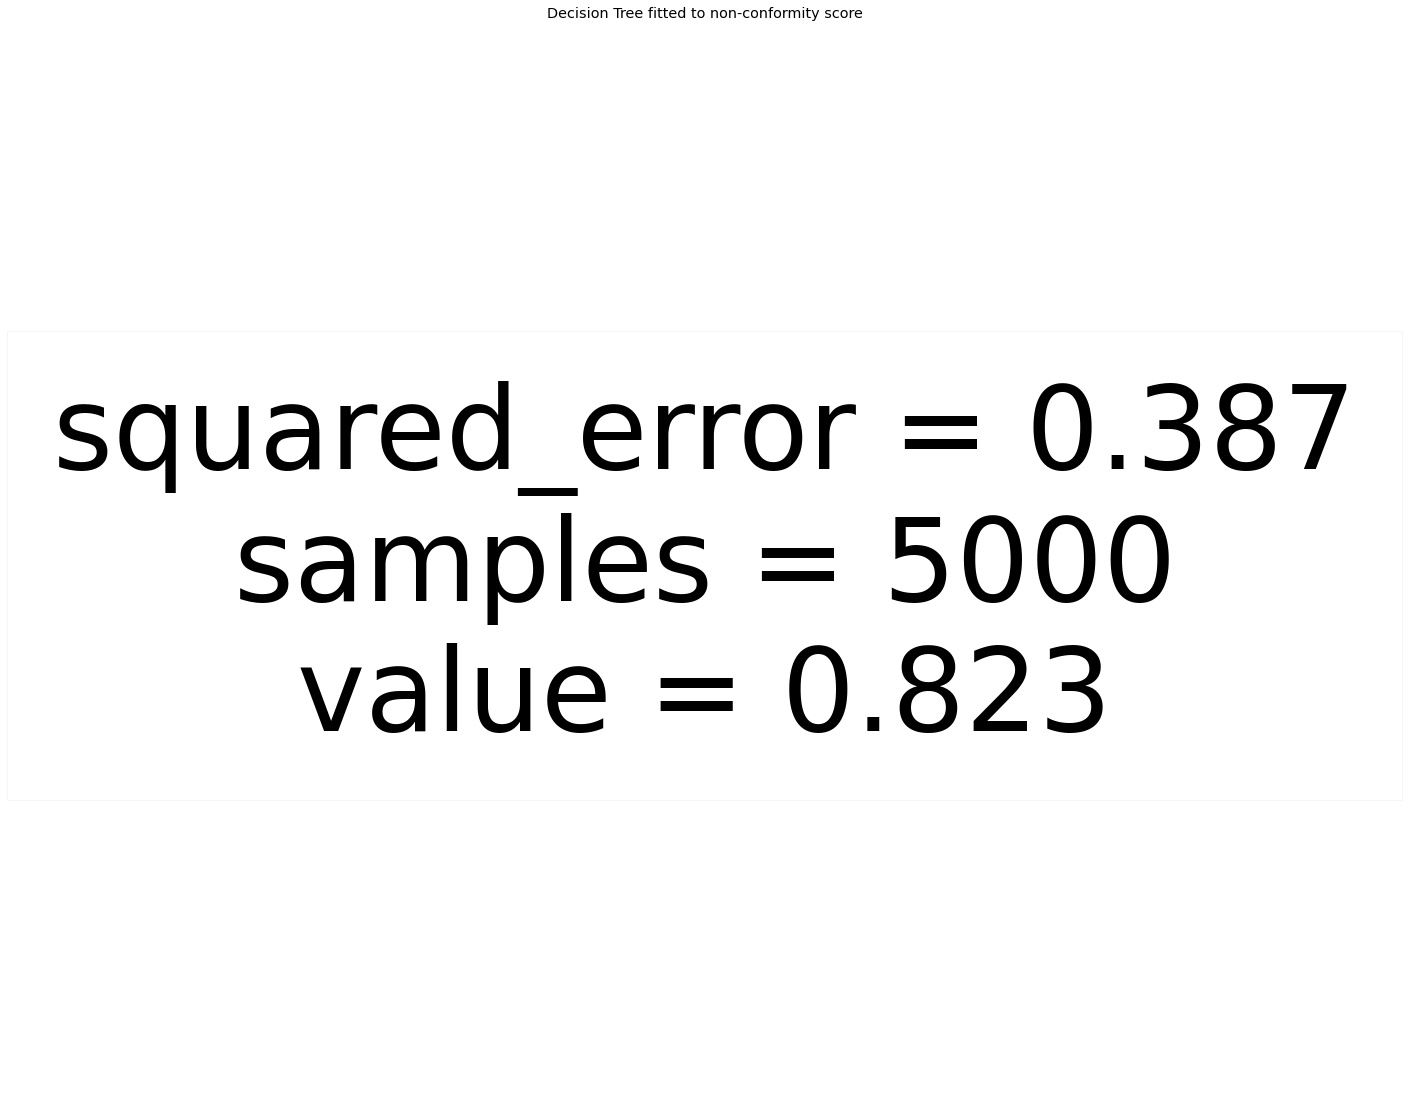

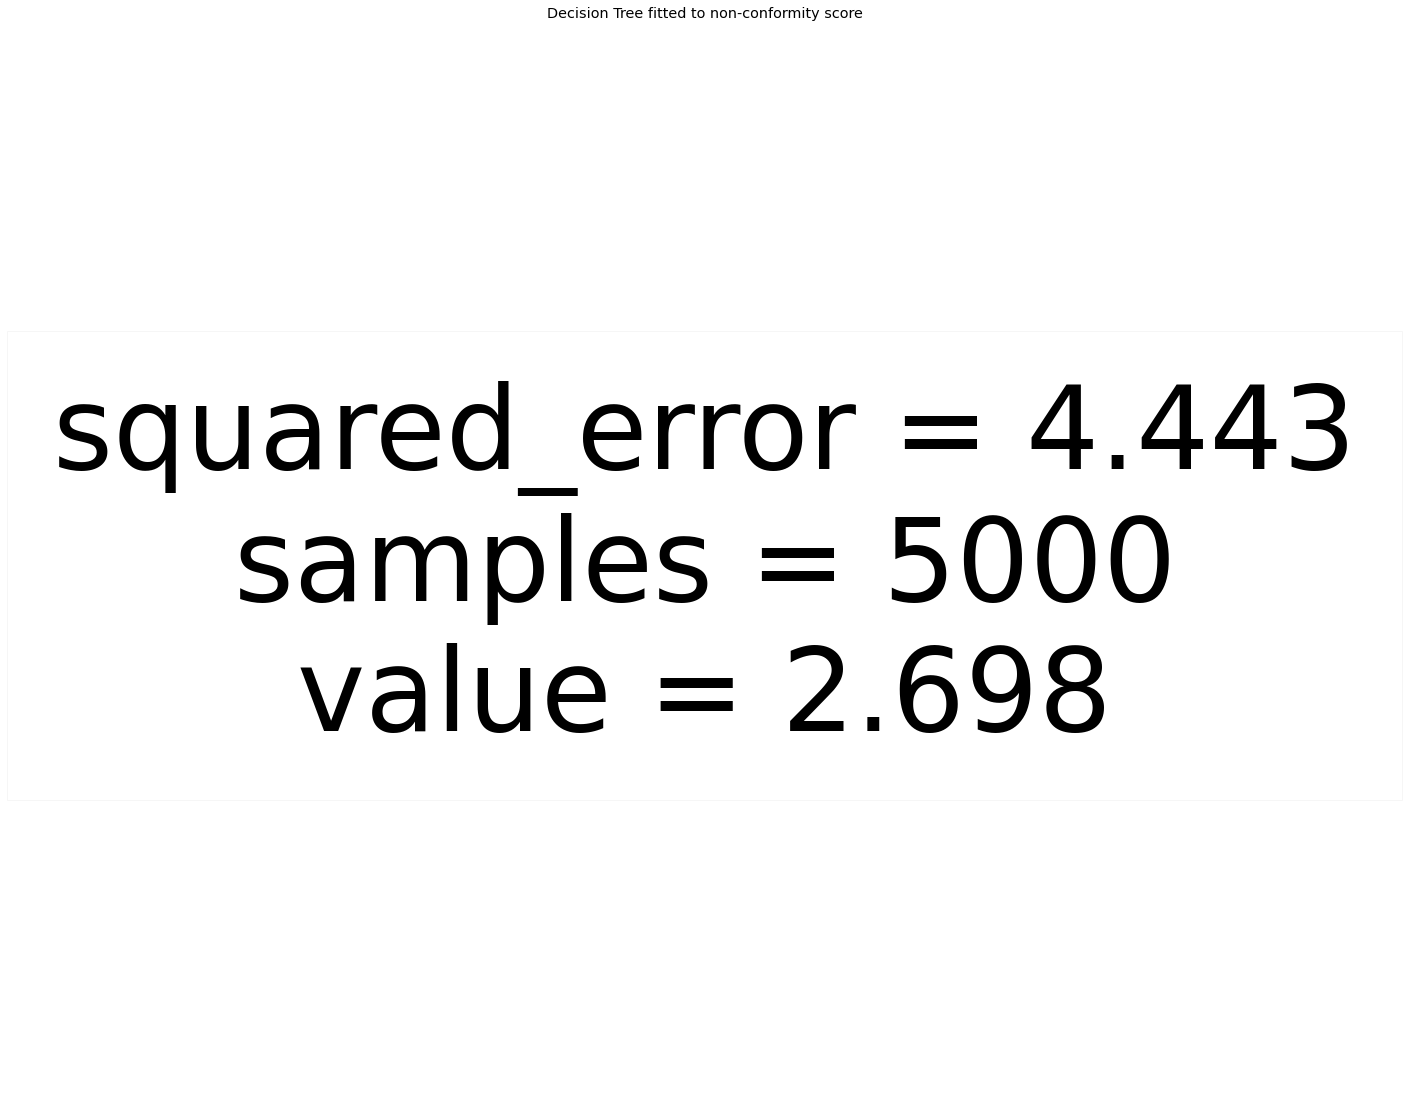

In [ ]:
# homoscedastic data
homoc_metrics = testing_metrics_sim(random_seed = 950, random_state = 650, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04404,-4.158279,0.094444,0.9066,3.375478,3.375478,0.011542,0.009,0.125
1,Weighted LOCART,0.04920,-4.251647,0.134615,0.9040,3.453297,3.474390,0.036356,0.031,0.223
2,Regresion split,0.04640,-4.158139,0.100000,0.9058,3.373234,3.373234,0.011517,0.009,0.125
3,Weighted regression split,0.05036,-4.254400,0.136641,0.9068,3.478703,3.499358,0.036112,0.031,0.219
4,Mondrian regression split,0.04788,-4.196410,0.106081,0.9046,3.386891,3.394603,0.023698,0.020,0.151


Fitting locart to toy example:
Time Elapsed to fit Locart:  30.864765405654907
Computing metrics
Time Elapsed to compute metrics for Locart:  1.6559576988220215
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  63.362555503845215
Computing metrics
Time Elapsed to compute metrics for Locart:  2.1954877376556396
Fitting regression split
Time Elapsed to fit regression split:  21.963252067565918
Computing metrics
Time Elapsed to compute statistics for regression split:  1.2485260963439941
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  49.307483434677124
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  49.307483434677124
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  20.225533485412598
Computing metrics
Cutoff points of wlocart: [5.48915238]
Cutoff point of wicp: 5.510769535483209


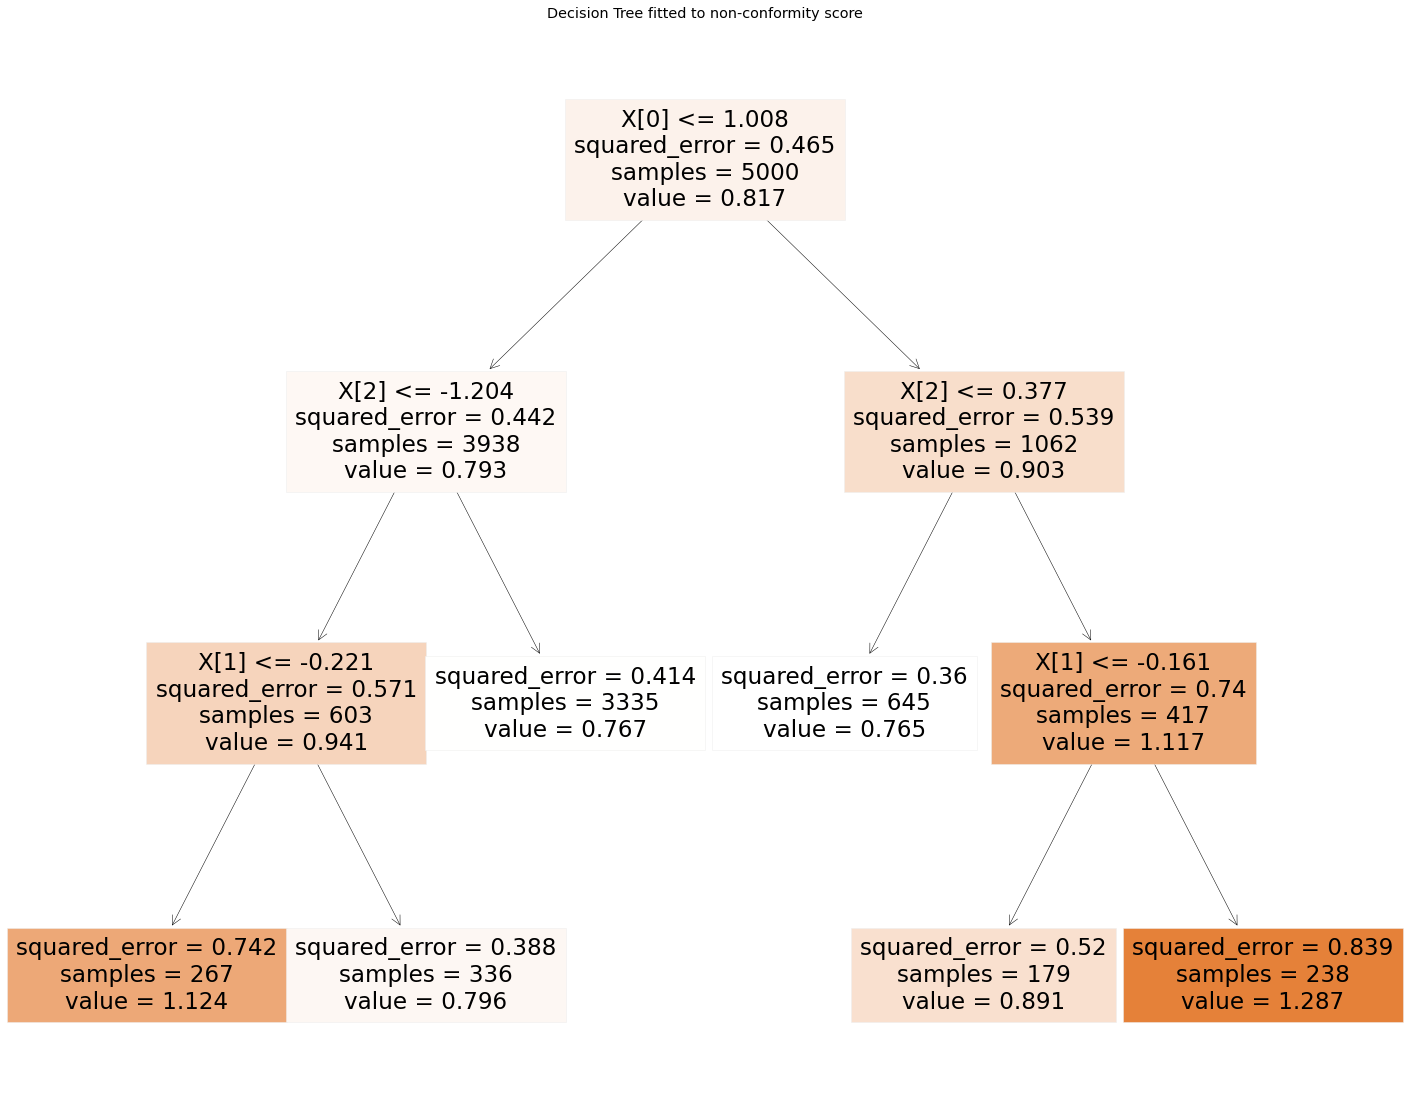

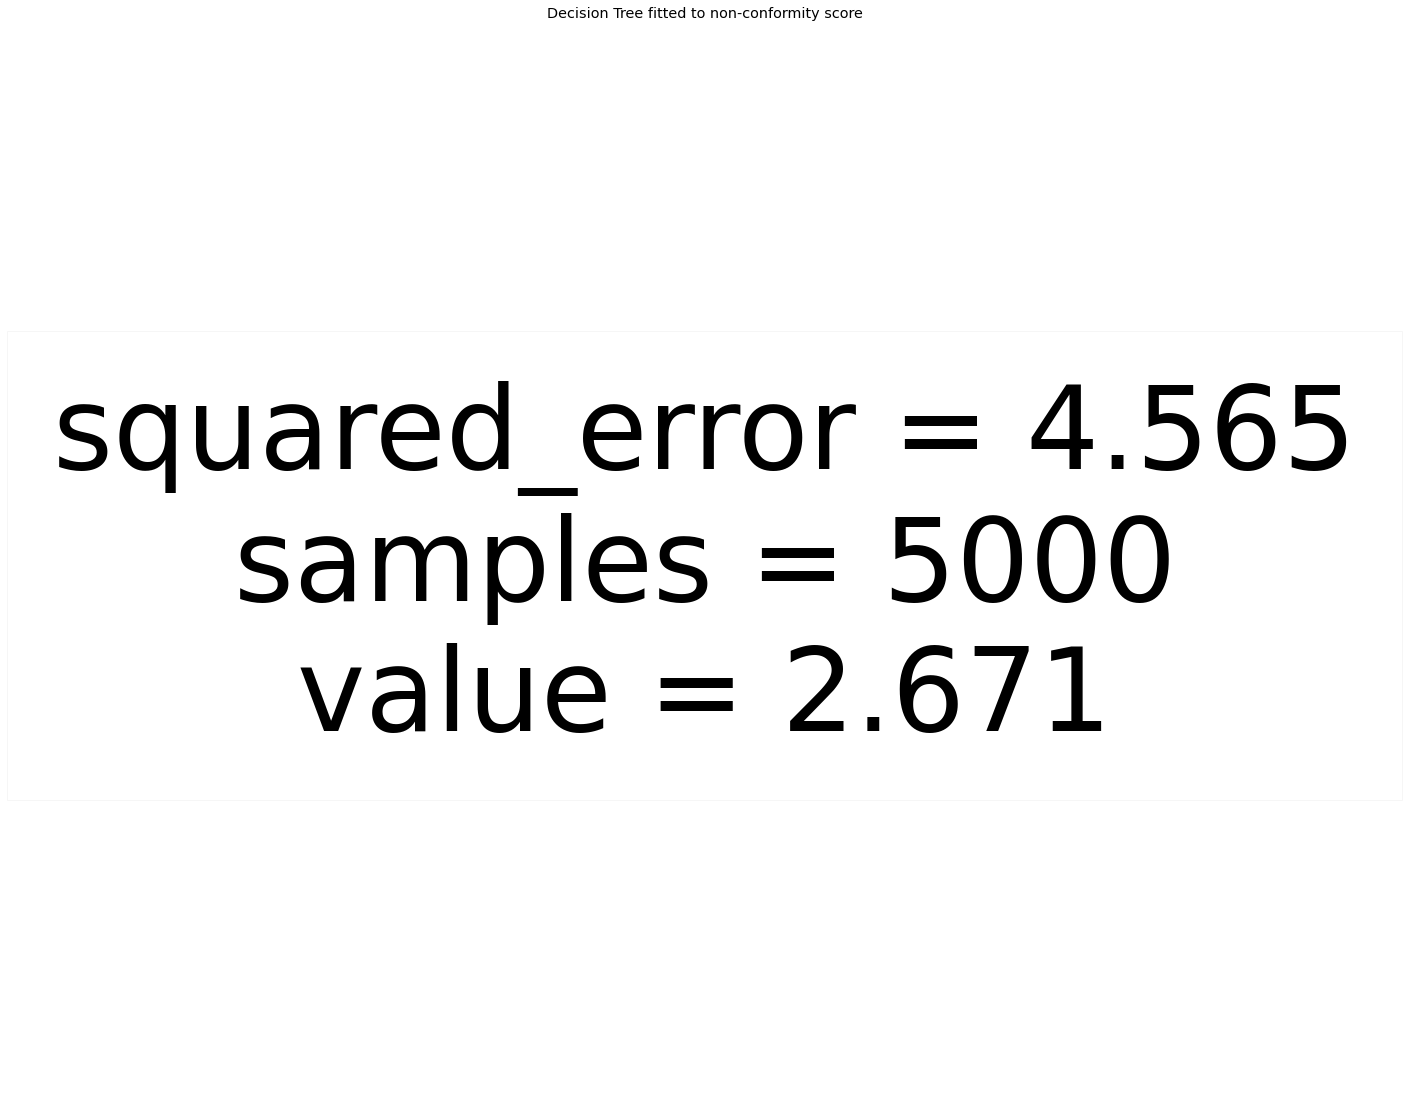

In [ ]:
# heteroscedastic data
heteroc_metrics = testing_metrics_sim(kind = "heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                    valid_test_size=0.5, nbins = 30, noise = False, random_projections= True,
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06328,-4.501895,0.225359,0.8978,3.419765,3.420917,0.064511,0.063,0.244
1,Weighted LOCART,0.05304,-4.347514,0.118519,0.8986,3.430004,3.443739,0.051523,0.046,0.272
2,Regresion split,0.06332,-4.550712,0.170000,0.8980,3.434371,3.434371,0.069063,0.067,0.291
3,Weighted regression split,0.05364,-4.347888,0.140310,0.8998,3.443512,3.457290,0.051282,0.046,0.271
4,Mondrian regression split,0.05108,-4.335960,0.111180,0.8952,3.315421,3.325152,0.048835,0.041,0.281


Fitting locart to toy example:
Time Elapsed to fit Locart:  28.435653924942017
Computing metrics
Time Elapsed to compute metrics for Locart:  1.8910536766052246
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  63.185224533081055
Computing metrics
Time Elapsed to compute metrics for Locart:  1.699765682220459
Fitting regression split
Time Elapsed to fit regression split:  22.72031879425049
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6399662494659424
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  55.84672784805298
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  55.84672784805298
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  21.82954168319702
Computing metrics
Cutoff points of wlocart: [4.92099754]
Cutoff point of wicp: 4.783252005349647


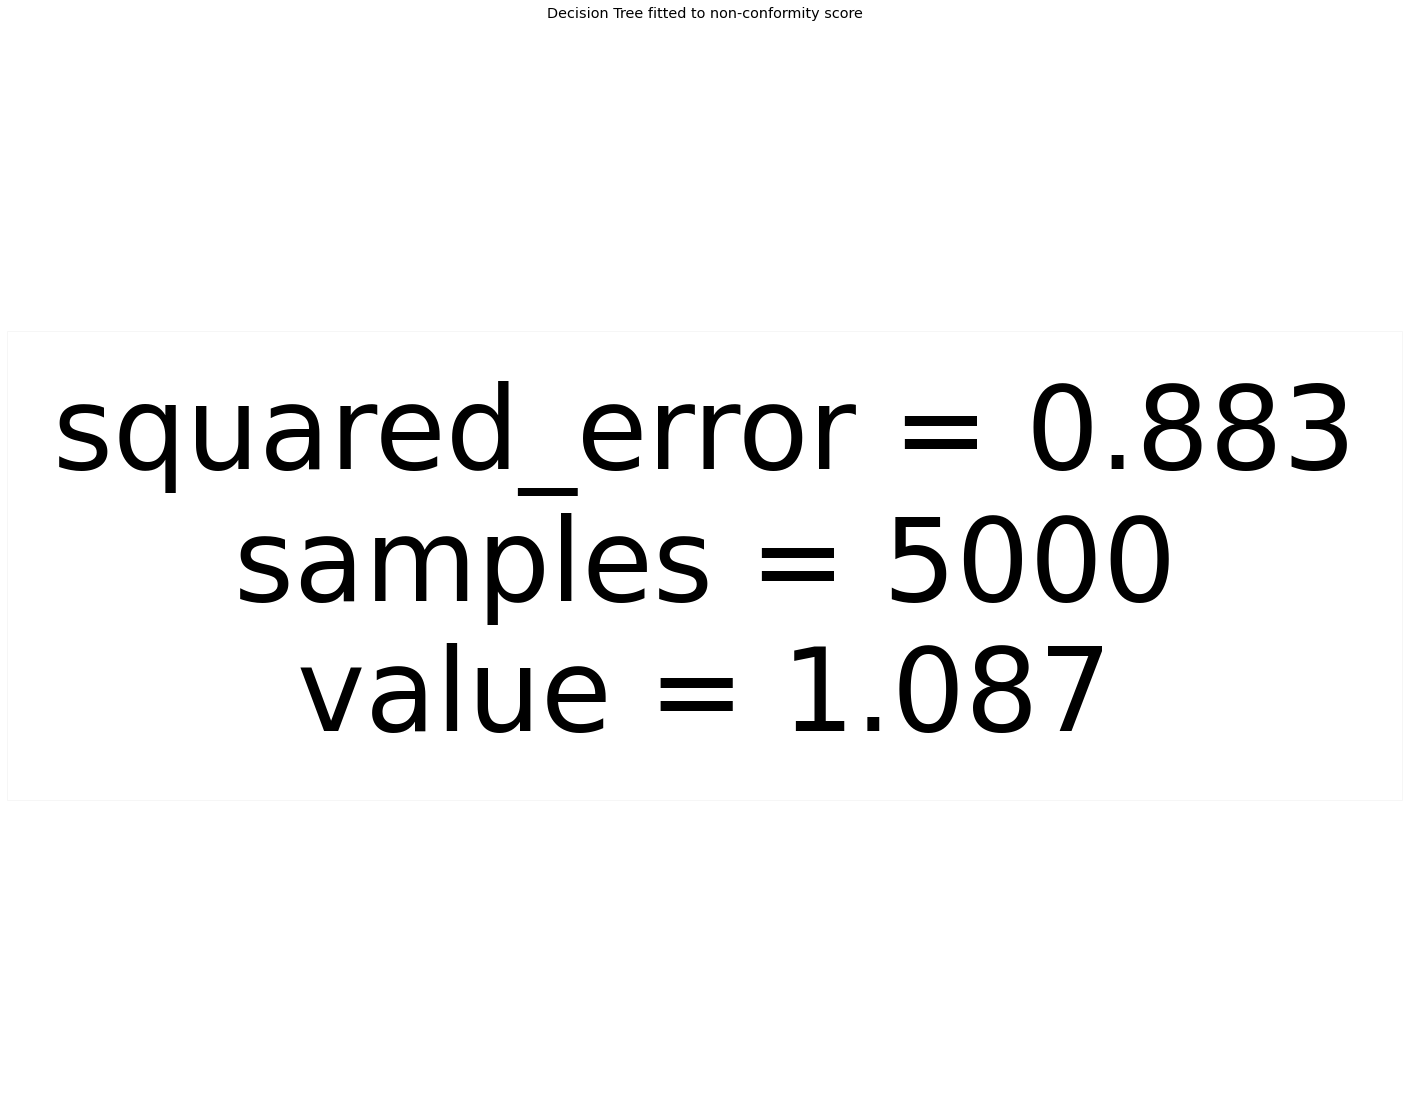

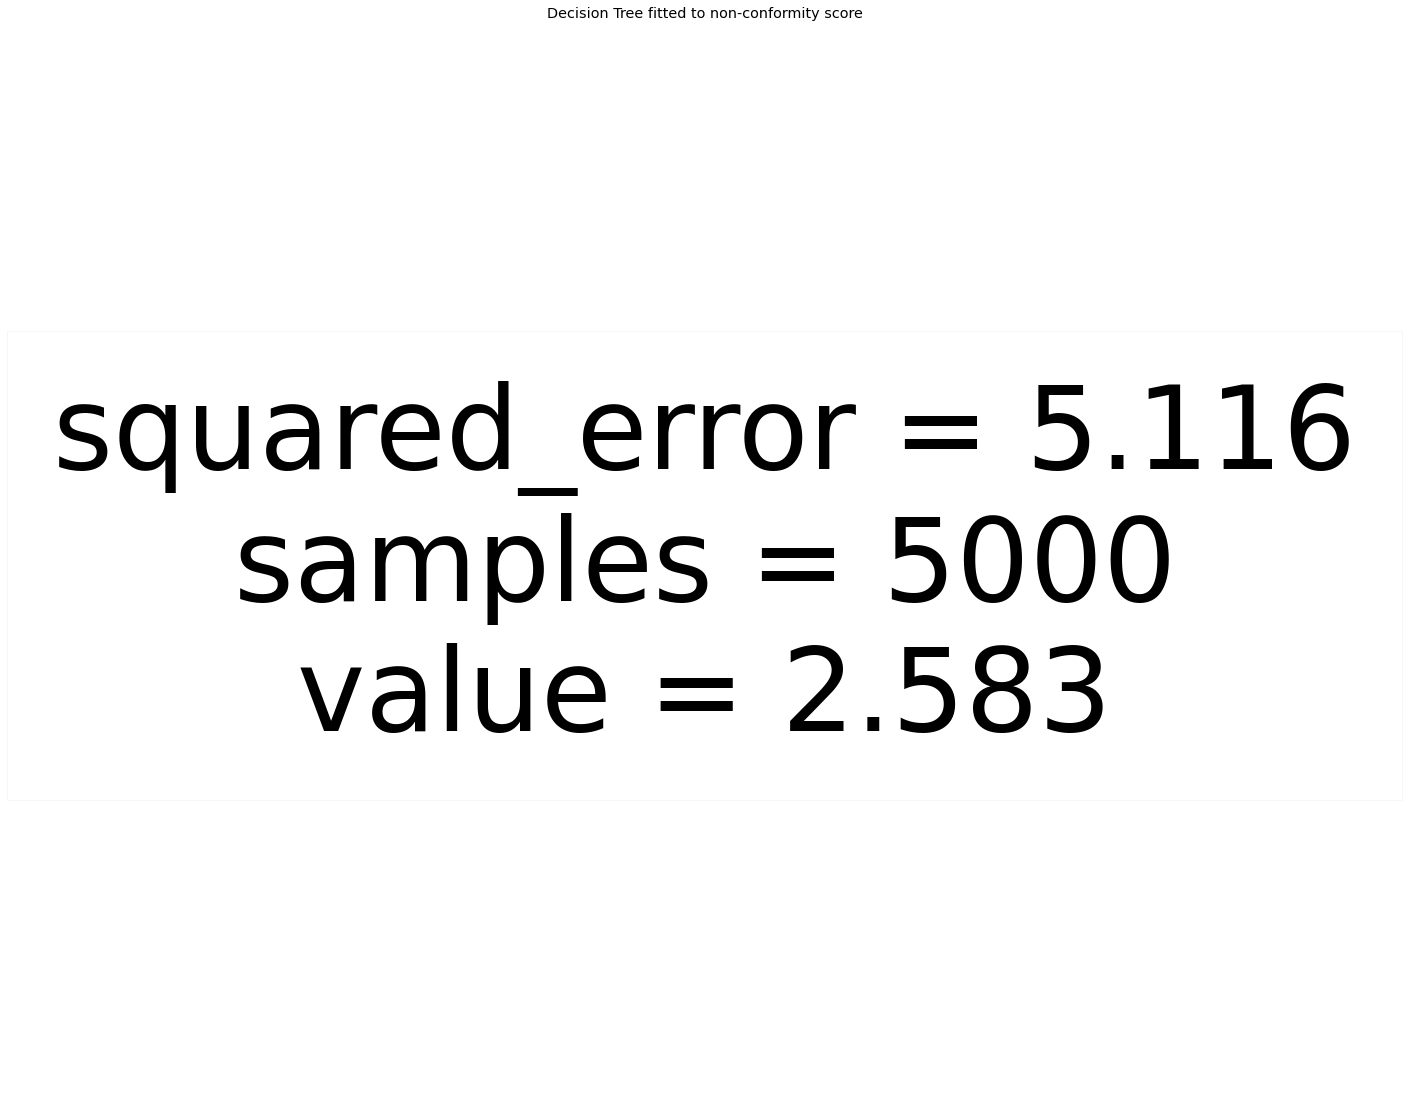

In [ ]:
asym_metrics = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 0.6, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True,  m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05392,-6.660768,0.166234,0.8998,4.237911,4.237911,0.050583,0.040,0.662
1,Weighted LOCART,0.04772,-6.576659,0.126744,0.9060,4.264658,4.291527,0.043622,0.037,0.400
2,Regresion split,0.05340,-6.661107,0.141830,0.8978,4.194824,4.194824,0.051259,0.040,0.670
3,Weighted regression split,0.04796,-6.566438,0.106667,0.8990,4.145284,4.173604,0.045452,0.038,0.420
4,Mondrian regression split,0.04548,-6.561430,0.113333,0.8984,4.023438,4.029078,0.045320,0.037,0.520


Fitting locart to toy example:
Time Elapsed to fit Locart:  28.76163387298584
Computing metrics
Time Elapsed to compute metrics for Locart:  1.7870800495147705
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  53.80260467529297
Computing metrics
Time Elapsed to compute metrics for Locart:  1.9777870178222656
Fitting regression split
Time Elapsed to fit regression split:  22.62430167198181
Computing metrics
Time Elapsed to compute statistics for regression split:  1.2425804138183594
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  51.63857340812683
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  51.63857340812683
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  22.869301795959473
Computing metrics
Cutoff points of wlocart: [4.80042497]
Cutoff point of wicp: 4.91897631369611


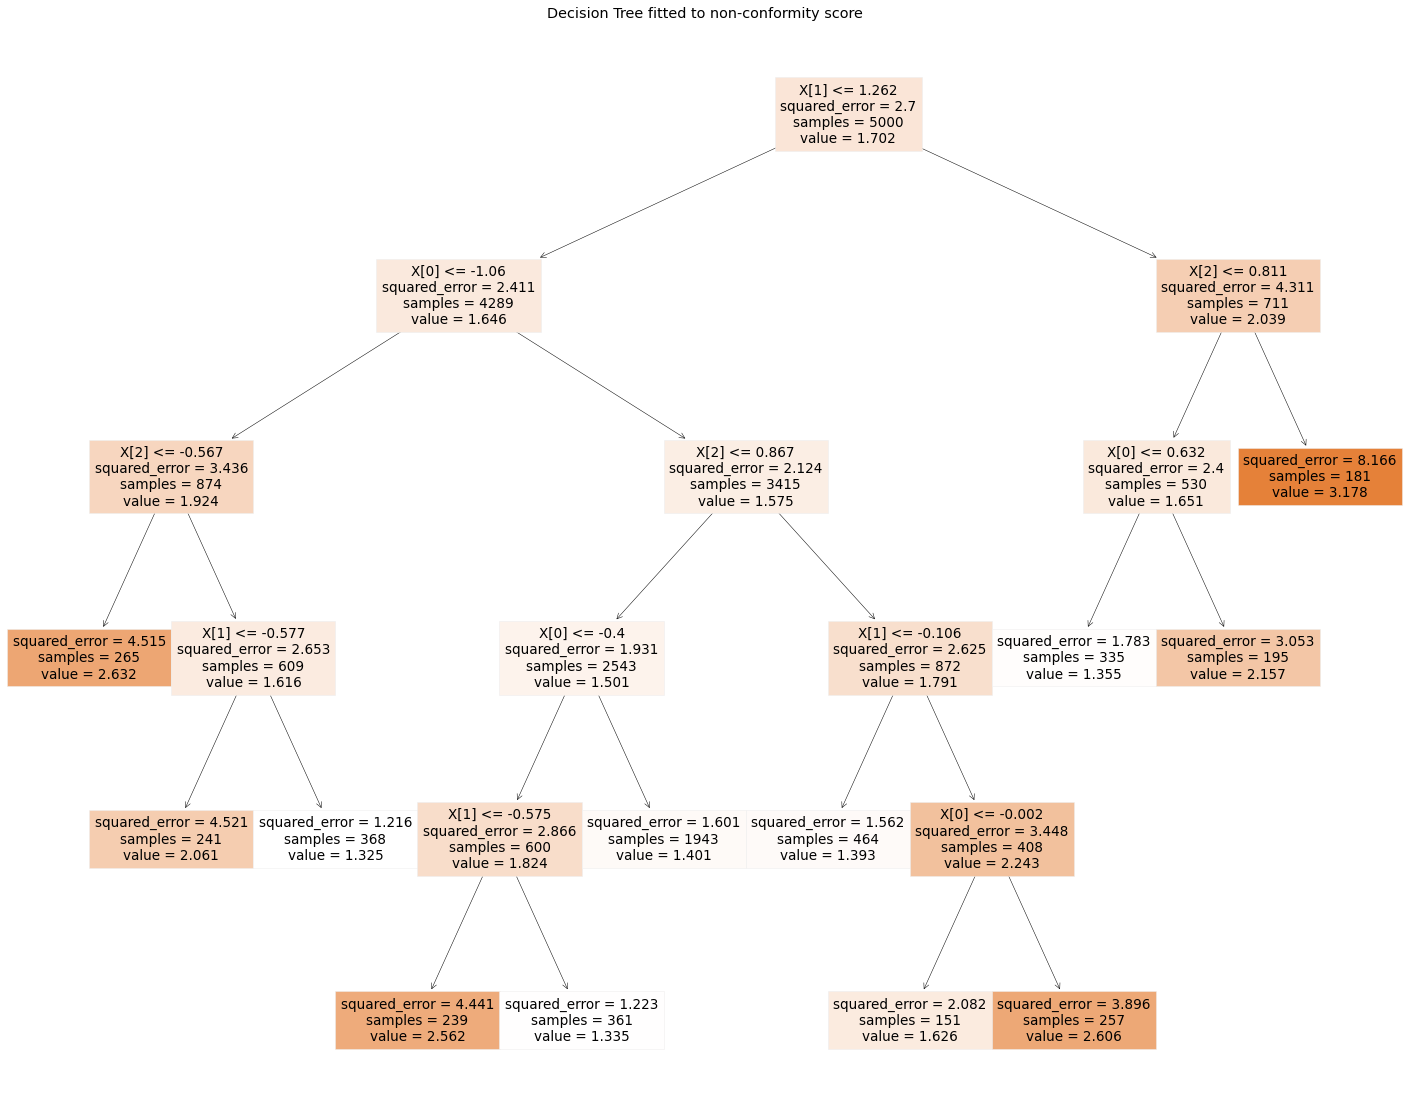

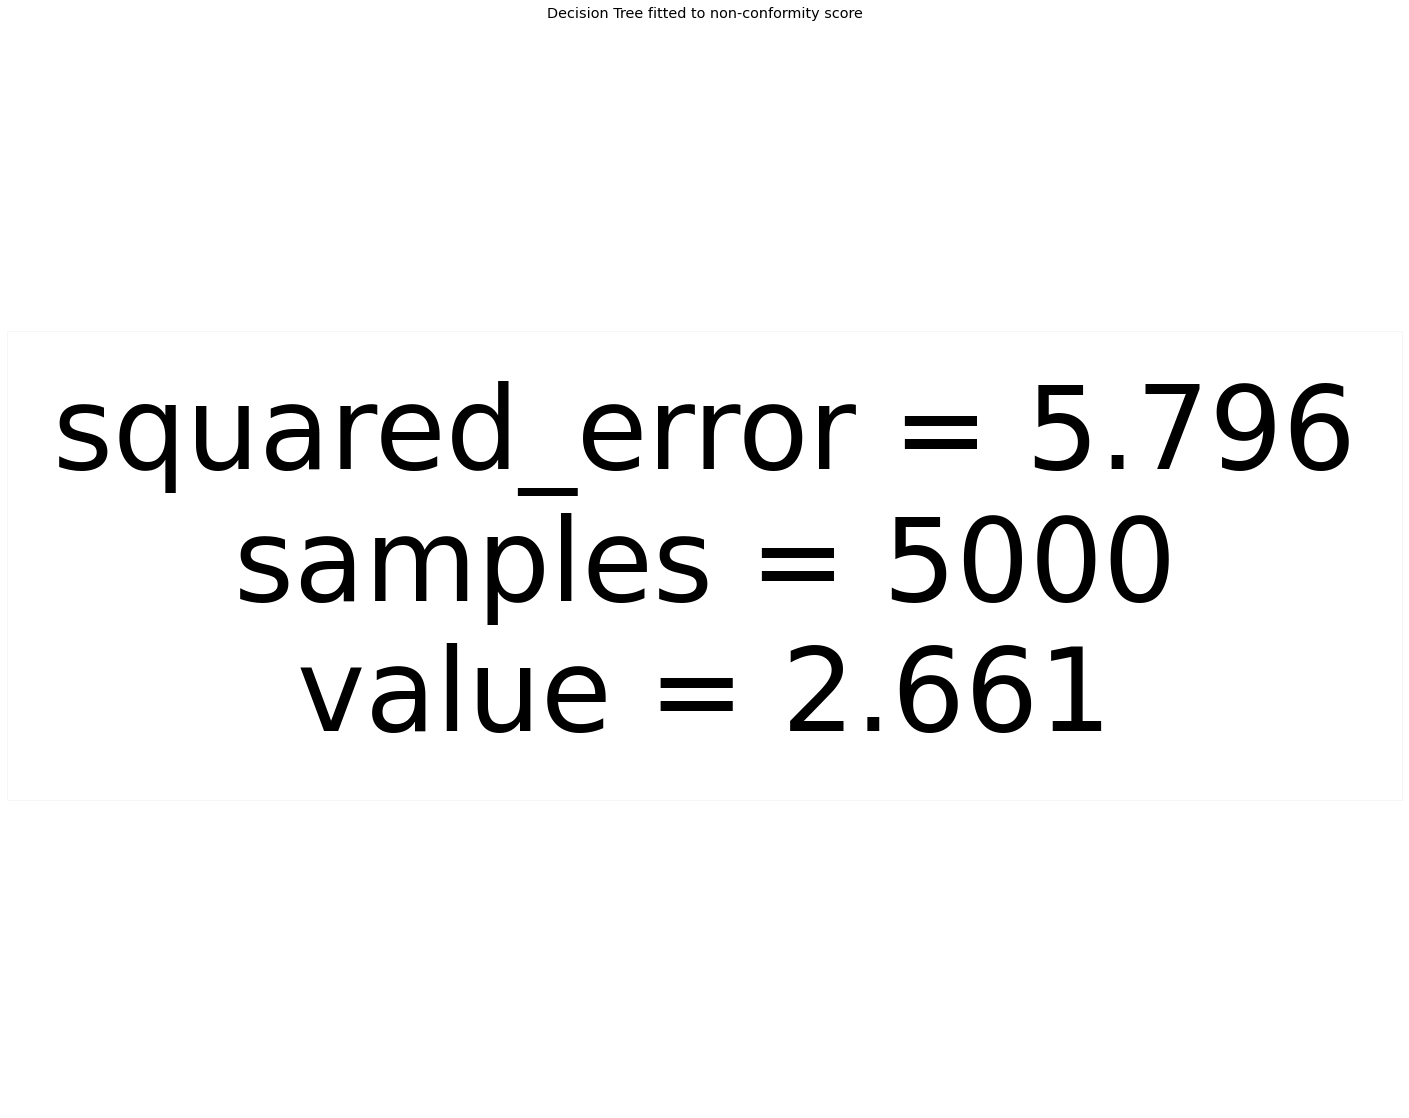

In [ ]:
asym_metrics_v2 = testing_metrics_sim(kind = "asymmetric", random_seed = 950, random_state = 650, asym_value = 1.5, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
asym_metrics_v2

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.04992,-10.005061,0.114286,0.8934,6.519888,6.519404,0.069567,0.057,0.766
1,Weighted LOCART,0.04912,-9.684699,0.144444,0.8966,6.295914,6.330520,0.055105,0.047,0.370
2,Regresion split,0.07356,-10.714973,0.197578,0.9036,7.099704,7.099704,0.080460,0.069,0.711
3,Weighted regression split,0.04836,-9.691890,0.145902,0.9026,6.451398,6.483677,0.052930,0.046,0.348
4,Mondrian regression split,0.05012,-9.701641,0.111921,0.8972,6.123849,6.162158,0.056985,0.047,0.391


Fitting locart to toy example:
Time Elapsed to fit Locart:  42.4189190864563
Computing metrics
Time Elapsed to compute metrics for Locart:  1.8948149681091309
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  67.53165769577026
Computing metrics
Time Elapsed to compute metrics for Locart:  2.097107172012329
Fitting regression split
Time Elapsed to fit regression split:  32.546205282211304
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8764441013336182
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  62.187278509140015
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  62.187278509140015
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  32.76859450340271
Computing metrics
Cutoff points of wlocart: [5.54338267]
Cutoff point of wicp: 5.535396329992402


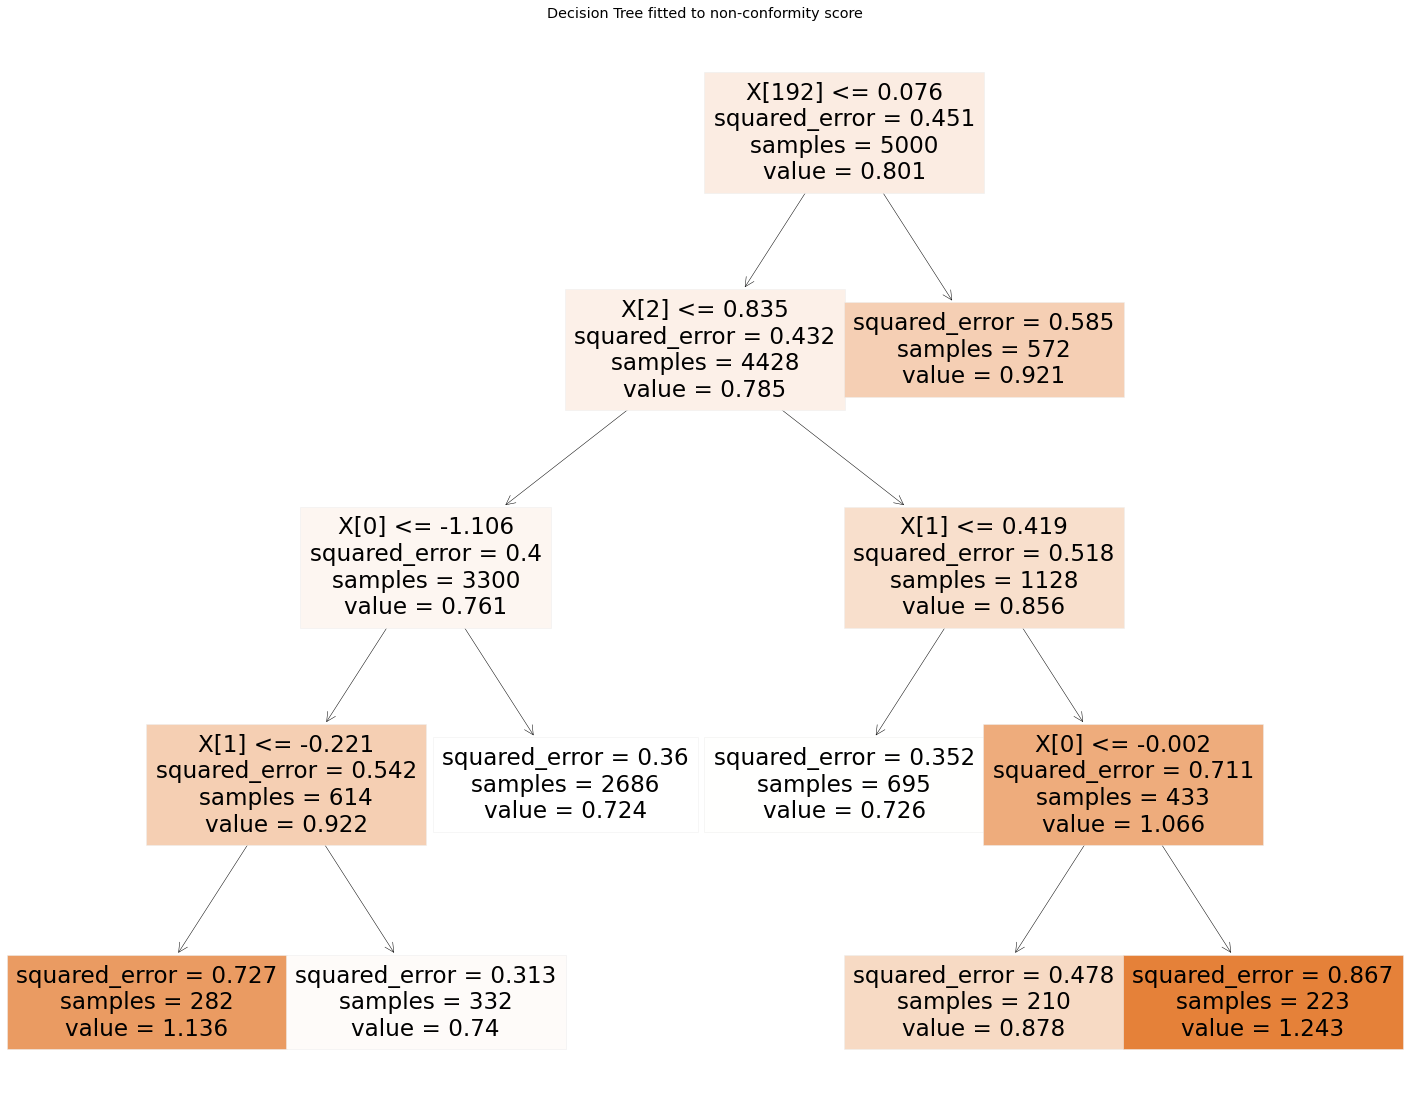

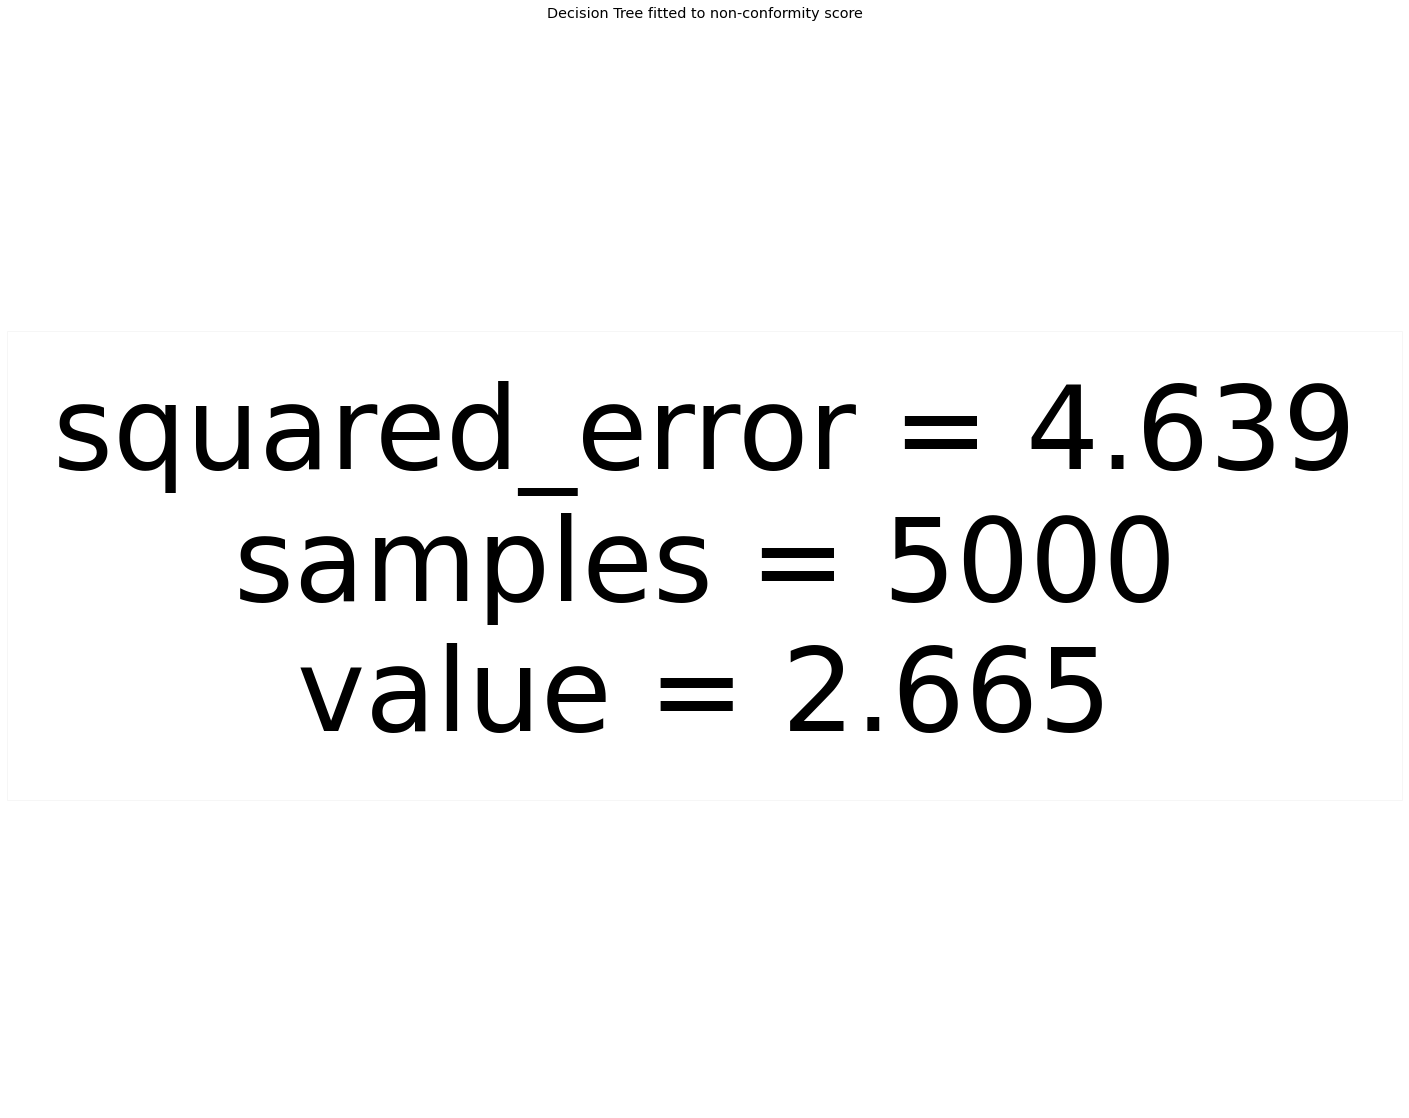

In [ ]:
non_cor_heteroc = testing_metrics_sim(kind = "non_cor_heteroscedastic", hetero_value = 0.25, random_seed = 950, random_state = 650,
                                      noise = False, valid_test_size = 0.5, nbins = 30, split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 100)

In [ ]:
non_cor_heteroc

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05604,-4.409186,0.206667,0.9014,3.402245,3.404007,0.062810,0.060,0.254
1,Weighted LOCART,0.04708,-4.311280,0.155682,0.9042,3.391303,3.404415,0.051391,0.046,0.243
2,Regresion split,0.06292,-4.477126,0.181106,0.8974,3.390198,3.390198,0.068783,0.067,0.265
3,Weighted regression split,0.04616,-4.310919,0.161628,0.9038,3.386417,3.399150,0.051503,0.046,0.243
4,Mondrian regression split,0.05028,-4.457172,0.120532,0.8998,3.416681,3.427898,0.065414,0.062,0.315


## Changing model to KNN and maintaining number of variables $p$:

Fitting locart to toy example:
Time Elapsed to fit Locart:  19.689209699630737
Computing metrics
Time Elapsed to compute metrics for Locart:  5.369230508804321
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  13.94277286529541
Computing metrics
Time Elapsed to compute metrics for Locart:  9.15253210067749
Fitting regression split
Time Elapsed to fit regression split:  3.254453182220459
Computing metrics
Time Elapsed to compute statistics for regression split:  3.682375431060791
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.718119621276855
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.718119621276855
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  20.083375930786133
Computing metrics
Cutoff points of wlocart: [2.19157276]
Cutoff point of wicp: 2.233610084971219


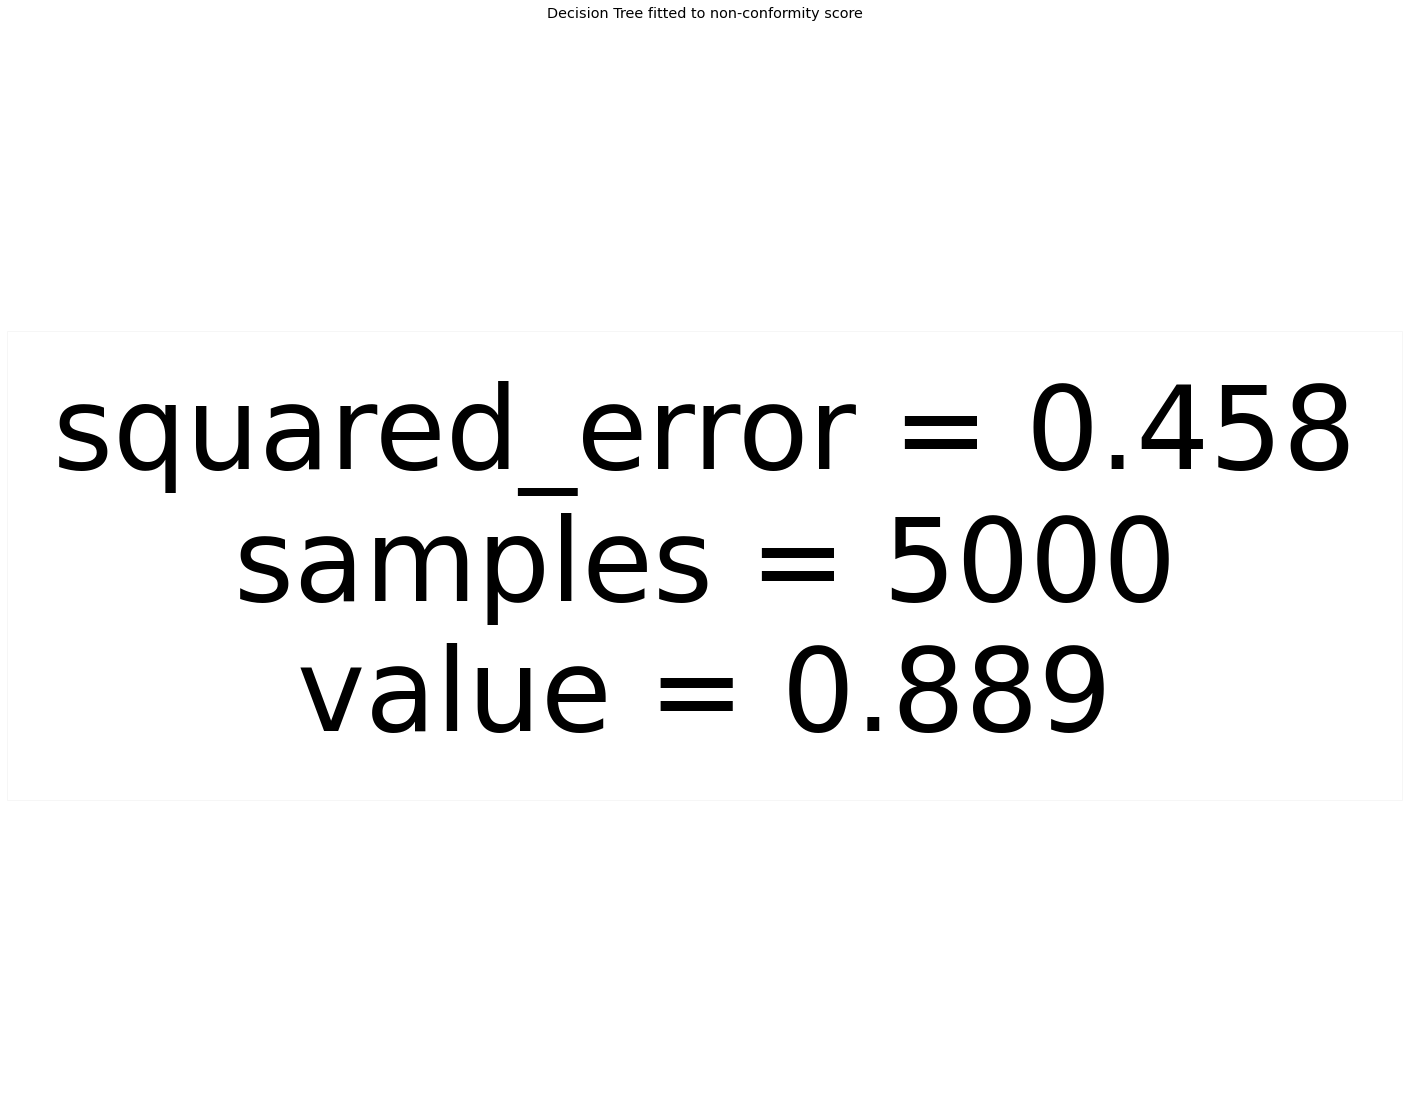

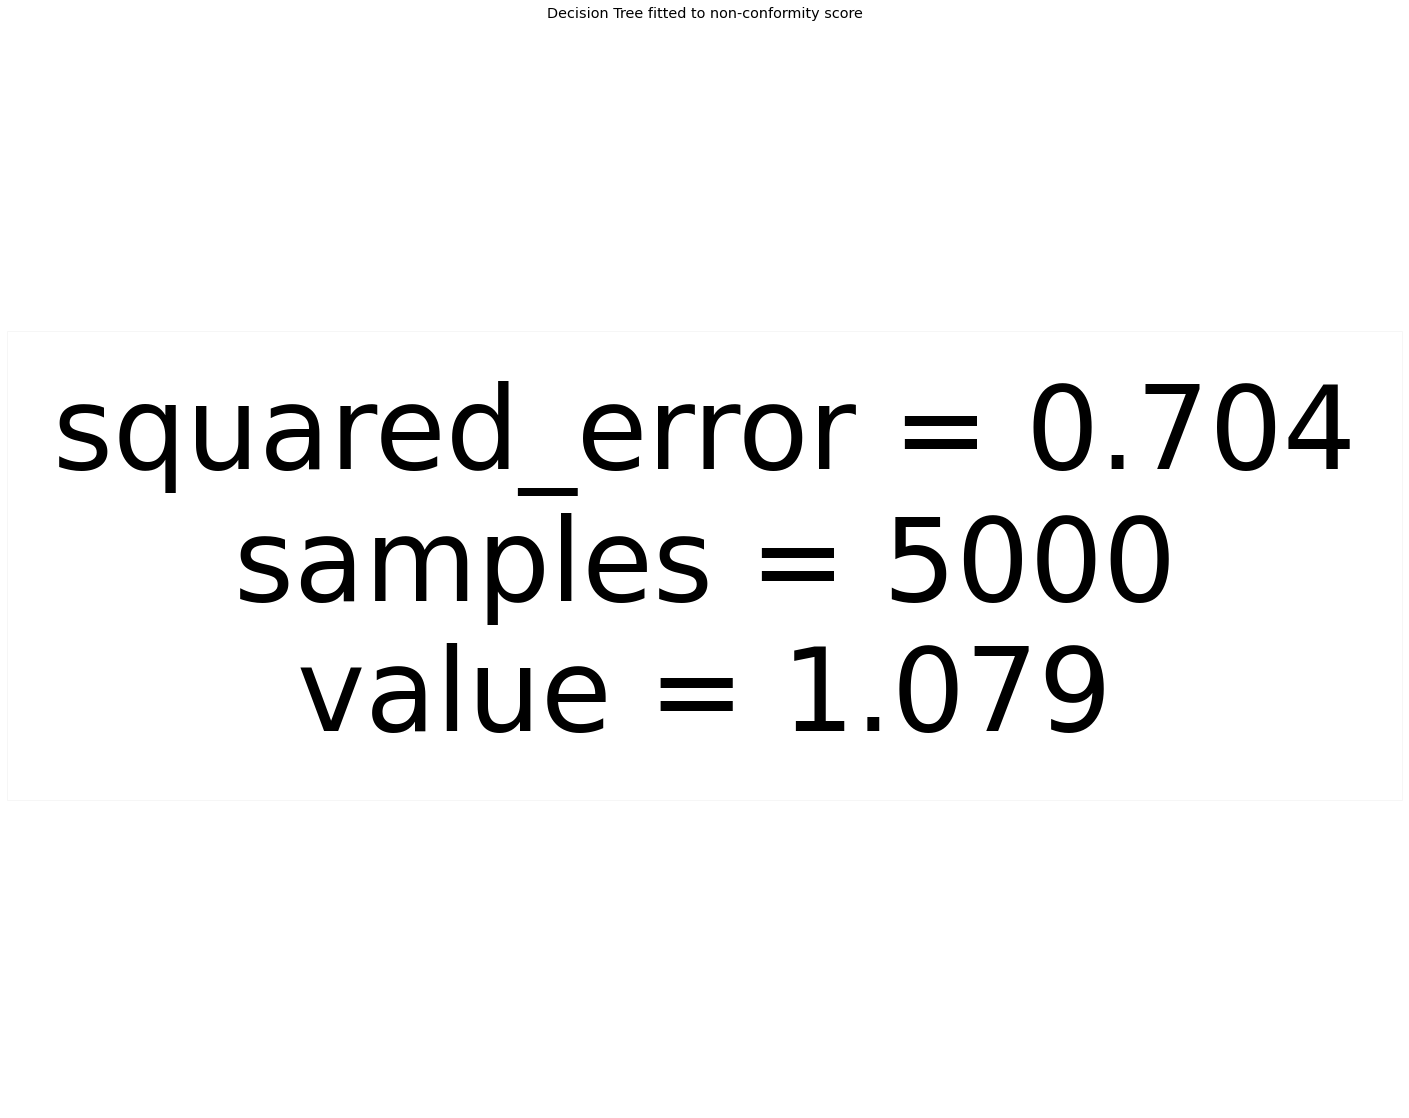

In [ ]:
homoc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, n_neighbors = 30, random_seed = 950, valid_test_size=0.5, nbins = 30, noise = False, 
                    split_calib = True, m = 300, valid_split = False, valid_prune = True, valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
homoc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05192,-4.522250,0.138739,0.9038,3.685293,3.685293,0.032953,0.027,0.335
1,Weighted LOCART,0.05100,-4.649125,0.117557,0.8962,3.685550,3.713165,0.048938,0.039,0.468
2,Regresion split,0.05192,-4.522481,0.138739,0.9038,3.691359,3.691359,0.033072,0.028,0.333
3,Weighted regression split,0.04928,-4.653176,0.148731,0.9018,3.756244,3.783794,0.048390,0.040,0.453
4,Mondrian regression split,0.05104,-4.540951,0.120000,0.8998,3.636644,3.641440,0.036561,0.028,0.341


Fitting locart to toy example:
Time Elapsed to fit Locart:  9.098684787750244
Computing metrics
Time Elapsed to compute metrics for Locart:  5.631527900695801
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  14.518782615661621
Computing metrics
Time Elapsed to compute metrics for Locart:  10.395574569702148
Fitting regression split
Time Elapsed to fit regression split:  3.3531155586242676
Computing metrics
Time Elapsed to compute statistics for regression split:  4.31364369392395
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.869263172149658
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.869263172149658
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  19.995317220687866
Computing metrics
Cutoff points of wlocart: [2.31011155]
Cutoff point of wicp: 2.3187401422254146


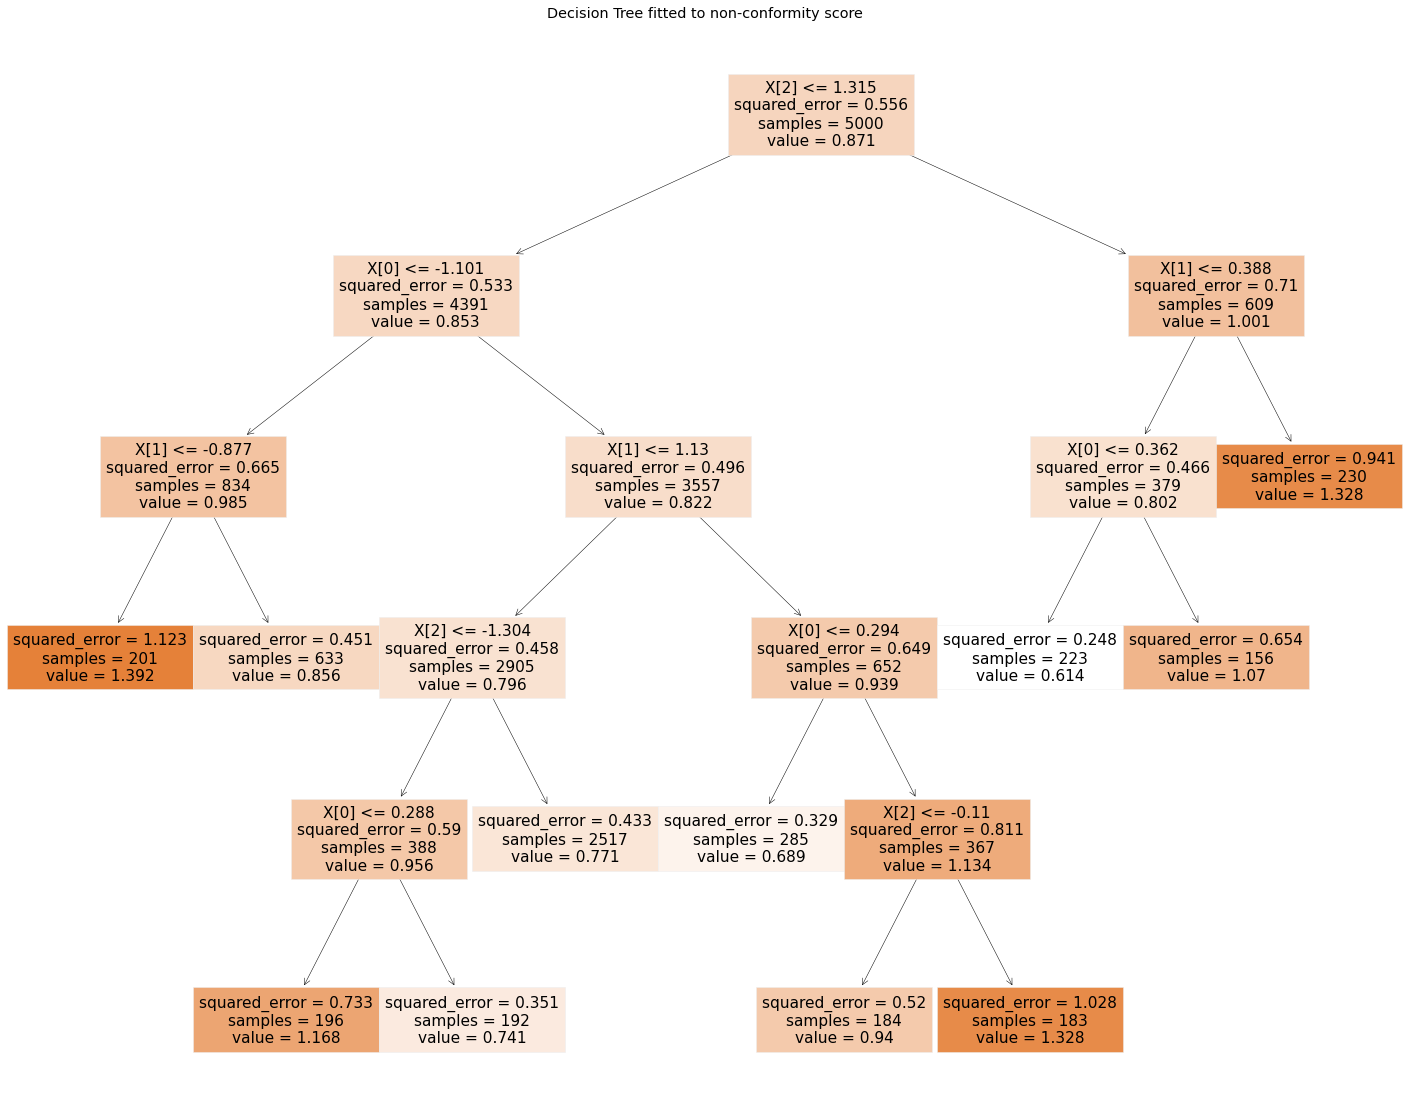

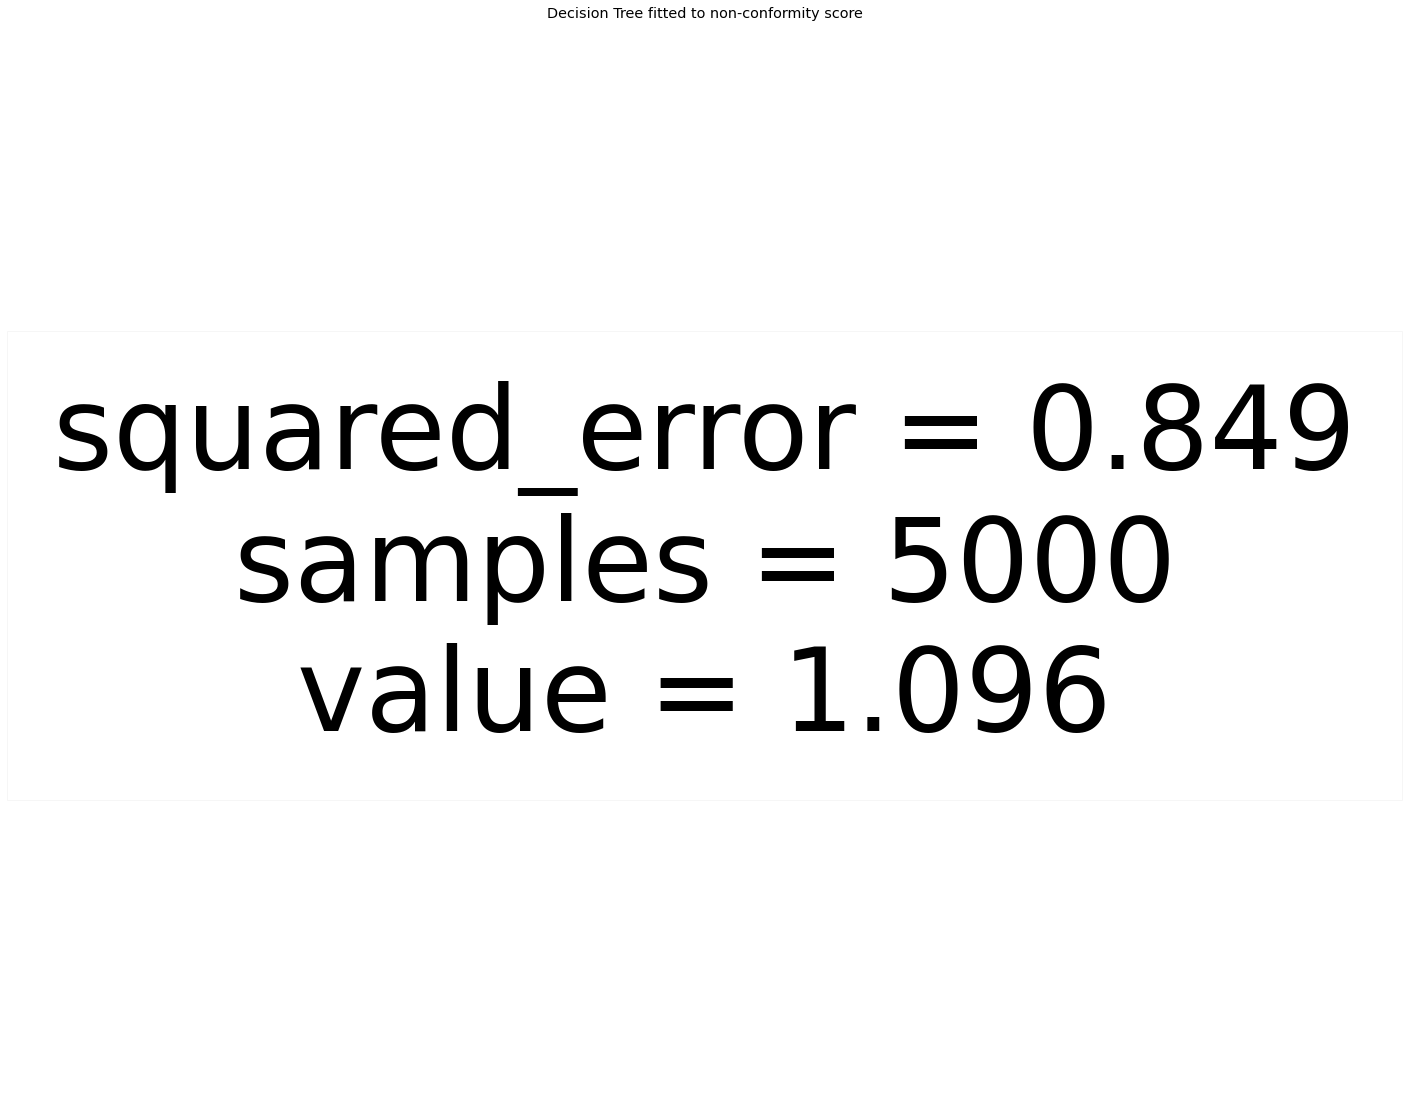

In [ ]:
heteroc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "heteroscedastic", n_neighbors = 30, hetero_value = 0.25, random_seed = 950,
                                      valid_test_size=0.5, nbins = 30, noise = False,  split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06820,-4.859357,0.265591,0.8870,3.596813,3.597350,0.071681,0.067,0.365
1,Weighted LOCART,0.05392,-4.903478,0.181437,0.8964,3.719327,3.730428,0.072467,0.067,0.403
2,Regresion split,0.07312,-4.966281,0.281910,0.9000,3.730715,3.730715,0.077942,0.075,0.393
3,Weighted regression split,0.05536,-4.903441,0.181437,0.8974,3.733219,3.744298,0.072194,0.067,0.399
4,Mondrian regression split,0.05396,-4.656295,0.140000,0.8886,3.522612,3.531040,0.055230,0.046,0.335


Fitting locart to toy example:
Time Elapsed to fit Locart:  12.246329545974731
Computing metrics
Time Elapsed to compute metrics for Locart:  5.7427544593811035
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  17.819116830825806
Computing metrics
Time Elapsed to compute metrics for Locart:  10.409858226776123
Fitting regression split
Time Elapsed to fit regression split:  3.152486801147461
Computing metrics
Time Elapsed to compute statistics for regression split:  5.10970139503479
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.66550588607788
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.66550588607788
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  30.449854373931885
Computing metrics
Cutoff points of wlocart: [2.05079679]
Cutoff point of wicp: 2.0299569477458355


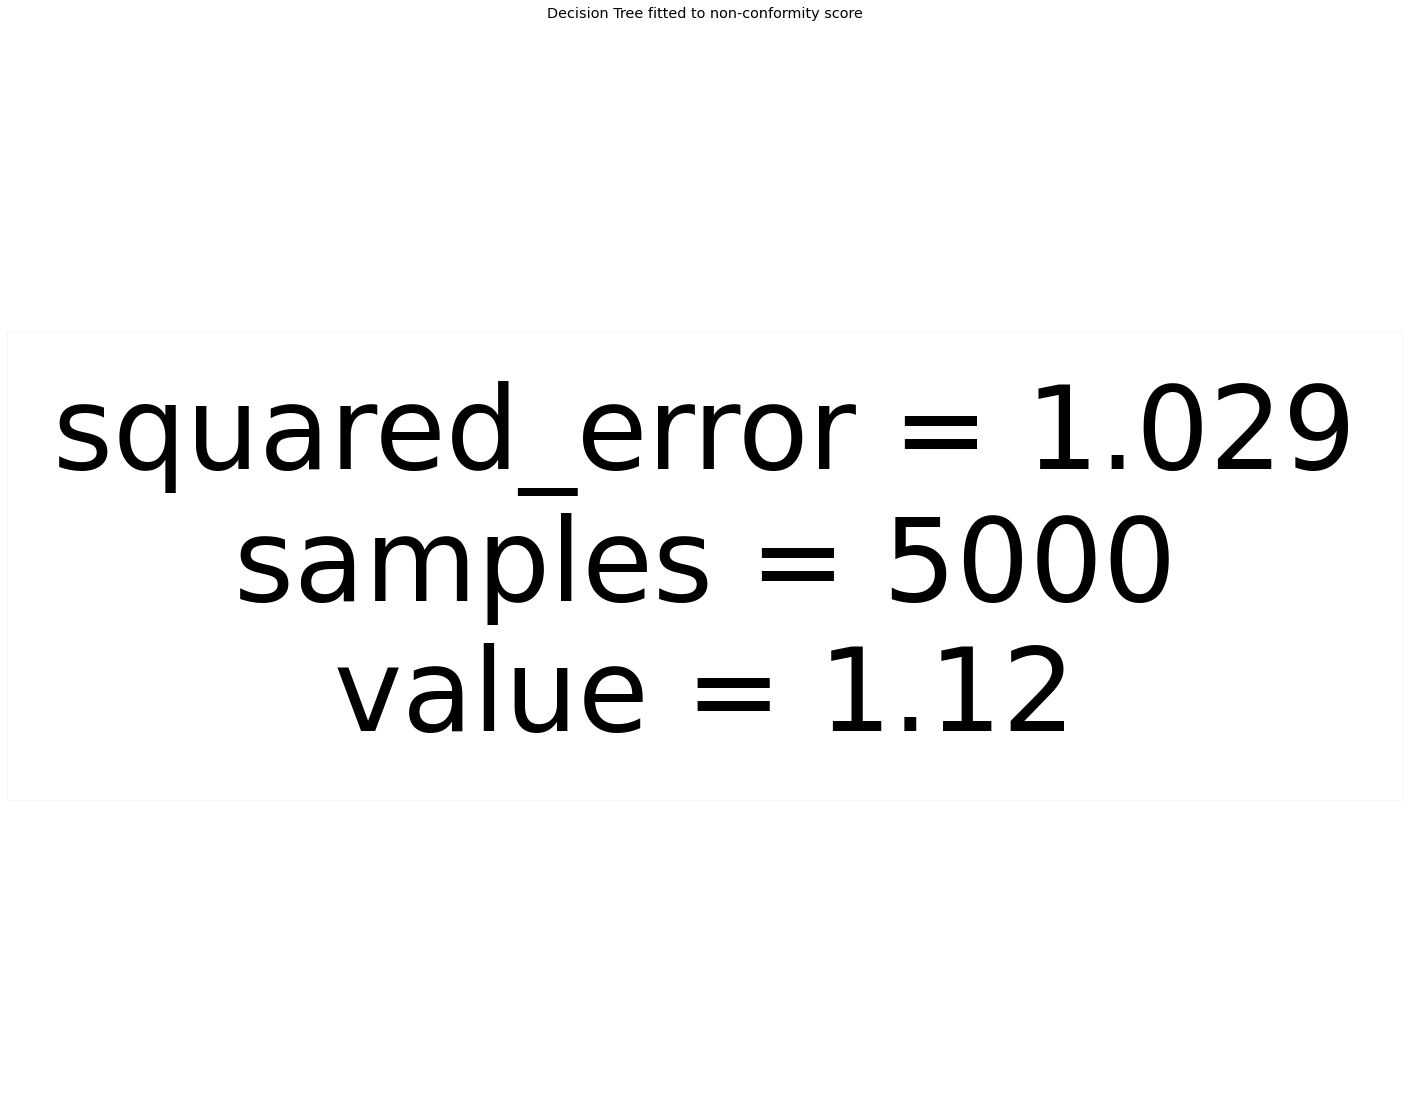

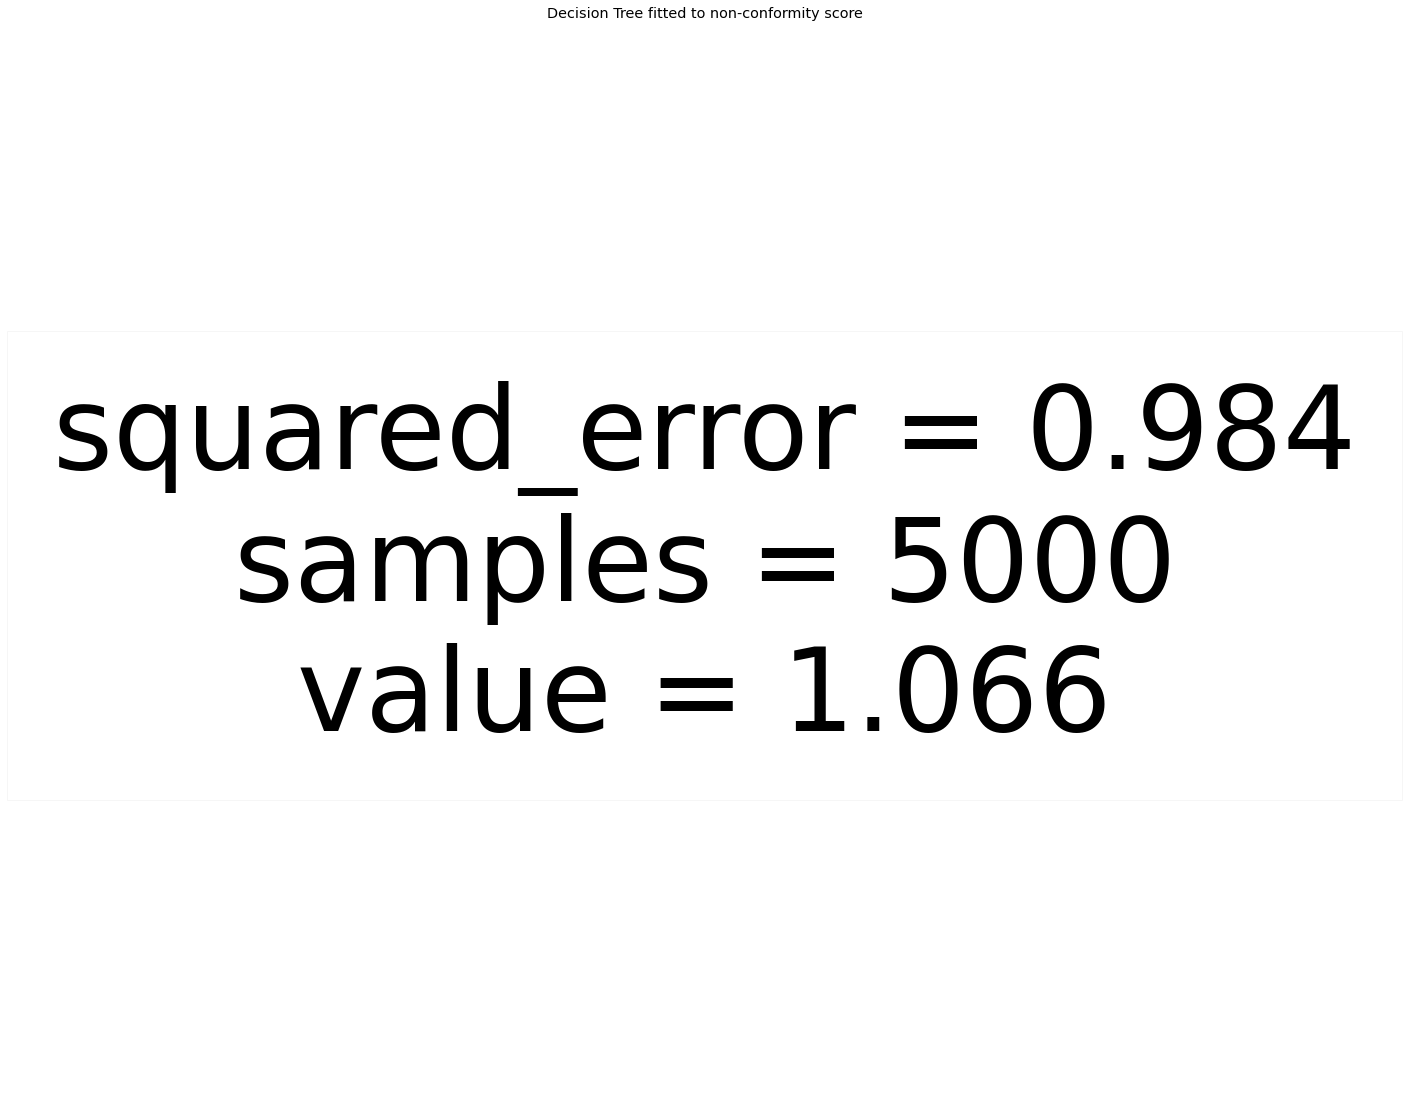

In [ ]:
asym_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "asymmetric", n_neighbors = 30, asym_value = 0.6, random_seed = 950, 
                                   valid_test_size=0.5, nbins = 30, noise = False, split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                   valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
asym_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06352,-7.242055,0.255263,0.8990,4.404342,4.404342,0.057448,0.049,0.421
1,Weighted LOCART,0.05624,-7.286458,0.212500,0.8938,4.376214,4.397031,0.055761,0.047,0.498
2,Regresion split,0.06080,-7.244004,0.268421,0.8946,4.330983,4.330983,0.058208,0.049,0.431
3,Weighted regression split,0.05684,-7.287492,0.212500,0.8924,4.331743,4.353254,0.056174,0.046,0.502
4,Mondrian regression split,0.05472,-7.108407,0.192398,0.8926,4.353831,4.355966,0.055379,0.045,0.490


Fitting locart to toy example:
Time Elapsed to fit Locart:  10.157236337661743
Computing metrics
Time Elapsed to compute metrics for Locart:  5.533715009689331
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  16.299165964126587
Computing metrics
Time Elapsed to compute metrics for Locart:  10.37571930885315
Fitting regression split
Time Elapsed to fit regression split:  3.265188694000244
Computing metrics
Time Elapsed to compute statistics for regression split:  4.325334548950195
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  9.542606592178345
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  9.542606592178345
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  27.820106029510498
Computing metrics
Cutoff points of wlocart: [1.92221087]
Cutoff point of wicp: 2.0057850824692247


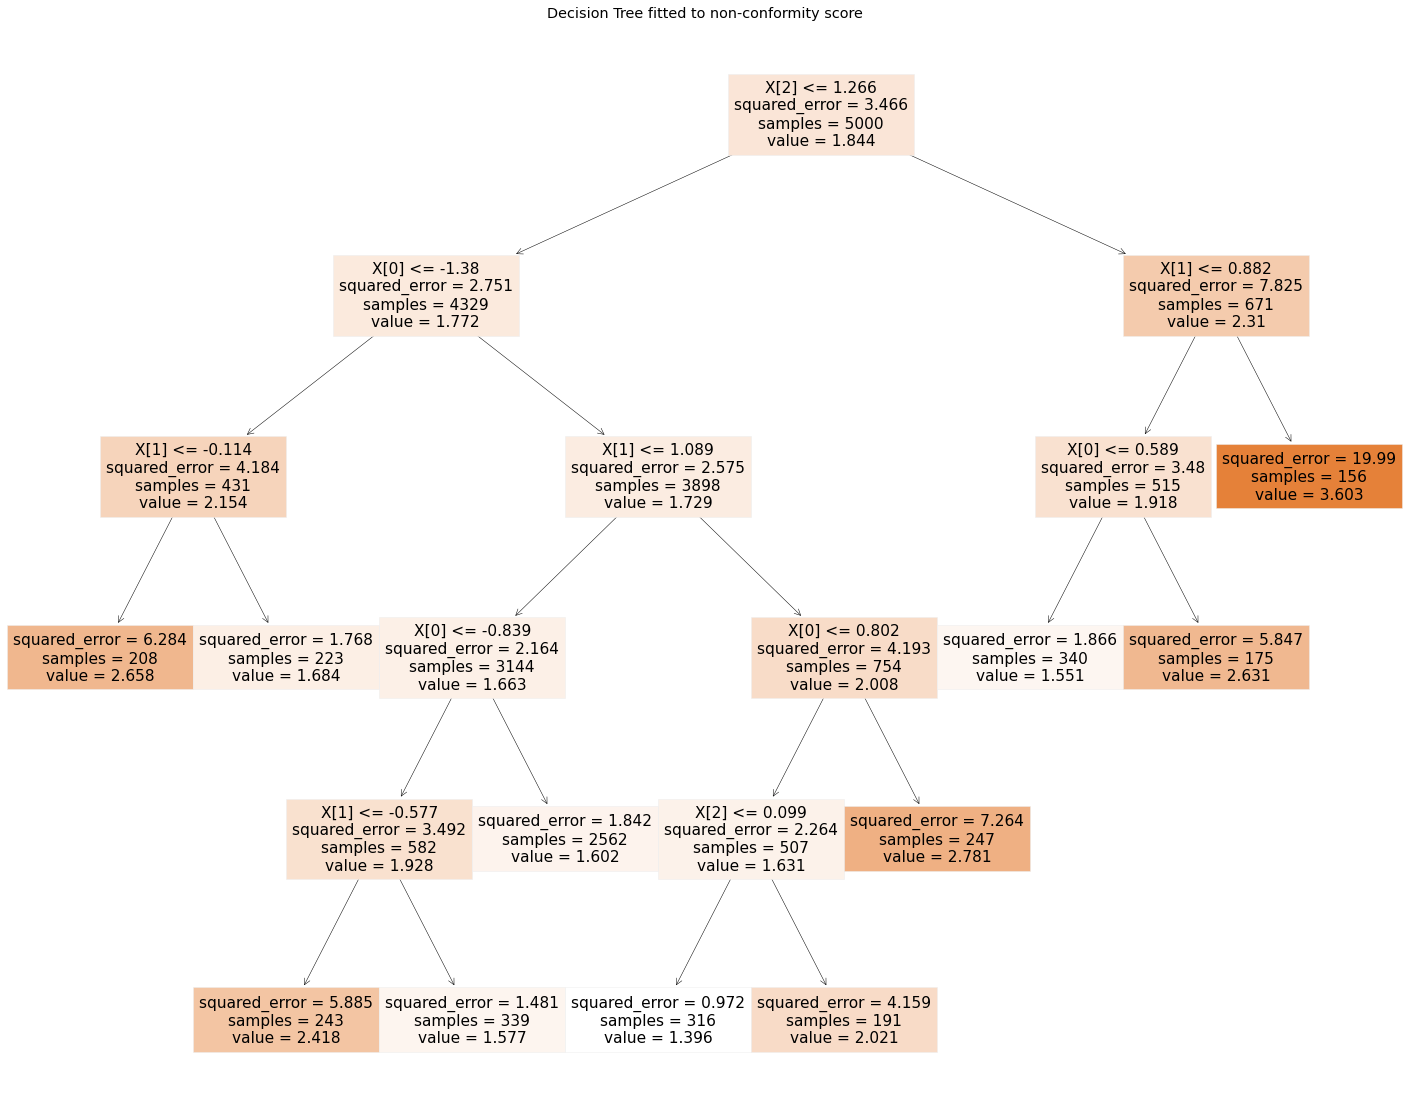

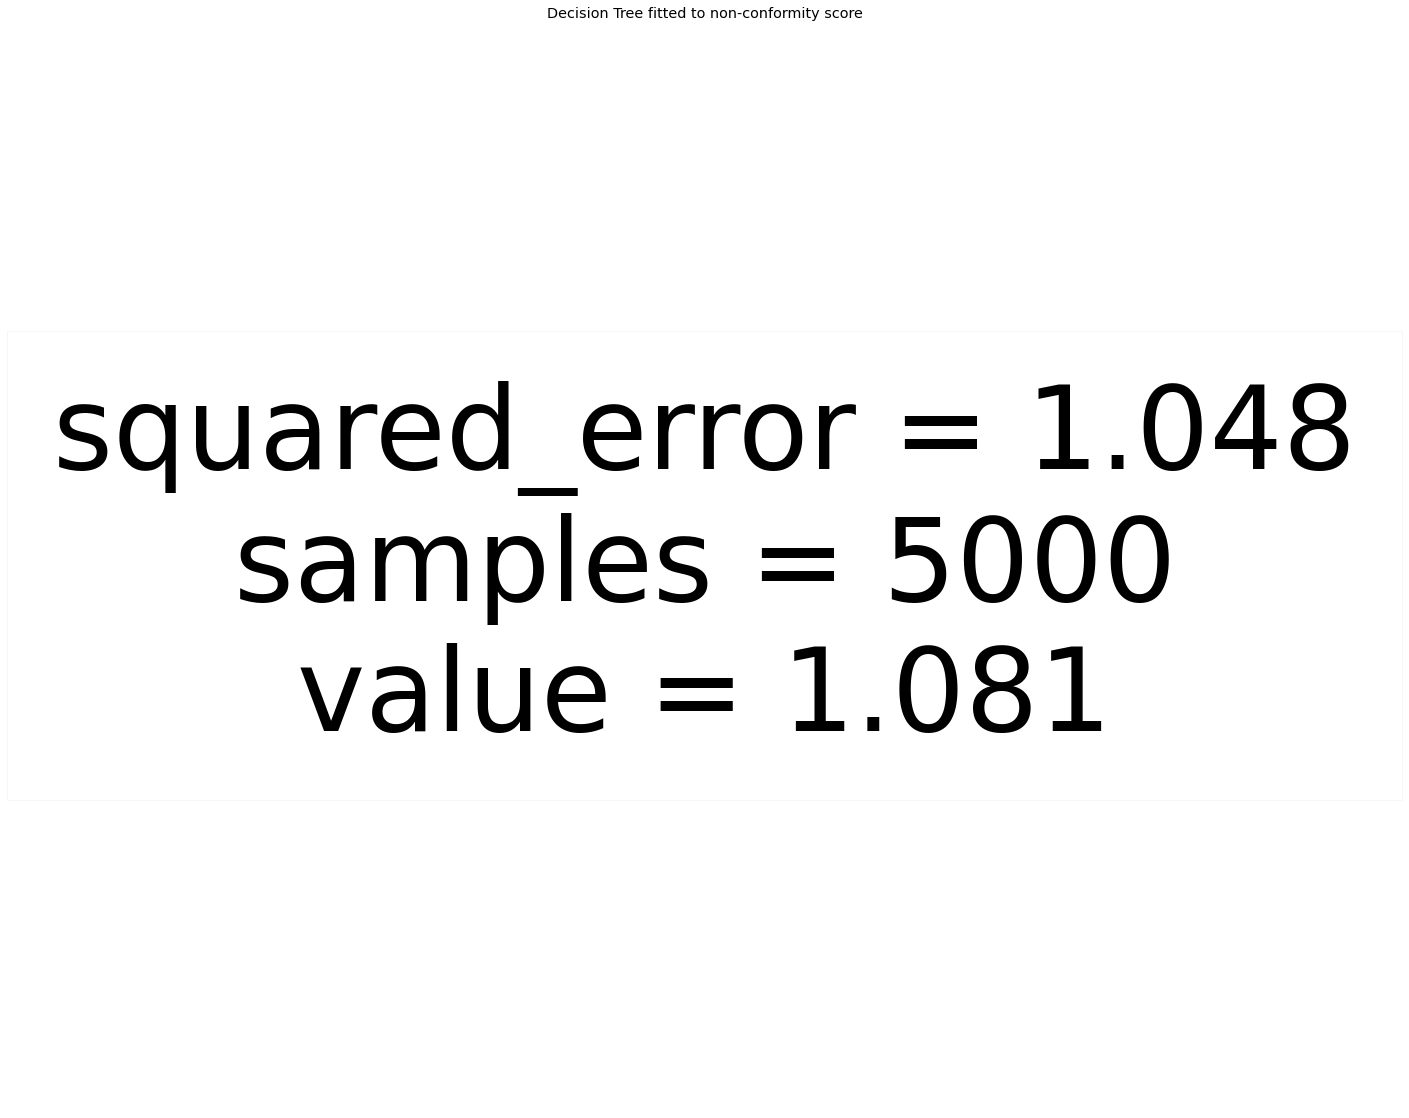

In [ ]:
asym_v2_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "asymmetric", n_neighbors = 30, asym_value = 1.5, random_seed = 950,
                                      valid_test_size=0.5, nbins = 30, noise = False, split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                      valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
asym_v2_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.06124,-11.295610,0.222097,0.8946,7.117271,7.139080,0.078047,0.069,0.654
1,Weighted LOCART,0.07572,-11.804936,0.259589,0.8920,6.568823,6.564253,0.081798,0.070,0.607
2,Regresion split,0.07864,-12.121243,0.425773,0.9030,7.033948,7.033948,0.086504,0.078,0.578
3,Weighted regression split,0.07352,-11.792740,0.251916,0.9002,6.854424,6.849438,0.079327,0.071,0.596
4,Mondrian regression split,0.05544,-10.833043,0.136287,0.8956,7.168416,7.176982,0.069254,0.058,0.578


Fitting locart to toy example:
Time Elapsed to fit Locart:  8.43742847442627
Computing metrics
Time Elapsed to compute metrics for Locart:  5.808401107788086
Fitting weighted locart to toy example:
Time Elapsed to fit Locart:  15.420174598693848
Computing metrics
Time Elapsed to compute metrics for Locart:  9.795548677444458
Fitting regression split
Time Elapsed to fit regression split:  3.2425026893615723
Computing metrics
Time Elapsed to compute statistics for regression split:  5.236151456832886
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  8.608797311782837
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  8.608797311782837
Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  37.41462302207947
Computing metrics
Cutoff points of wlocart: [2.29940216]
Cutoff point of wicp: 2.2791154569877263


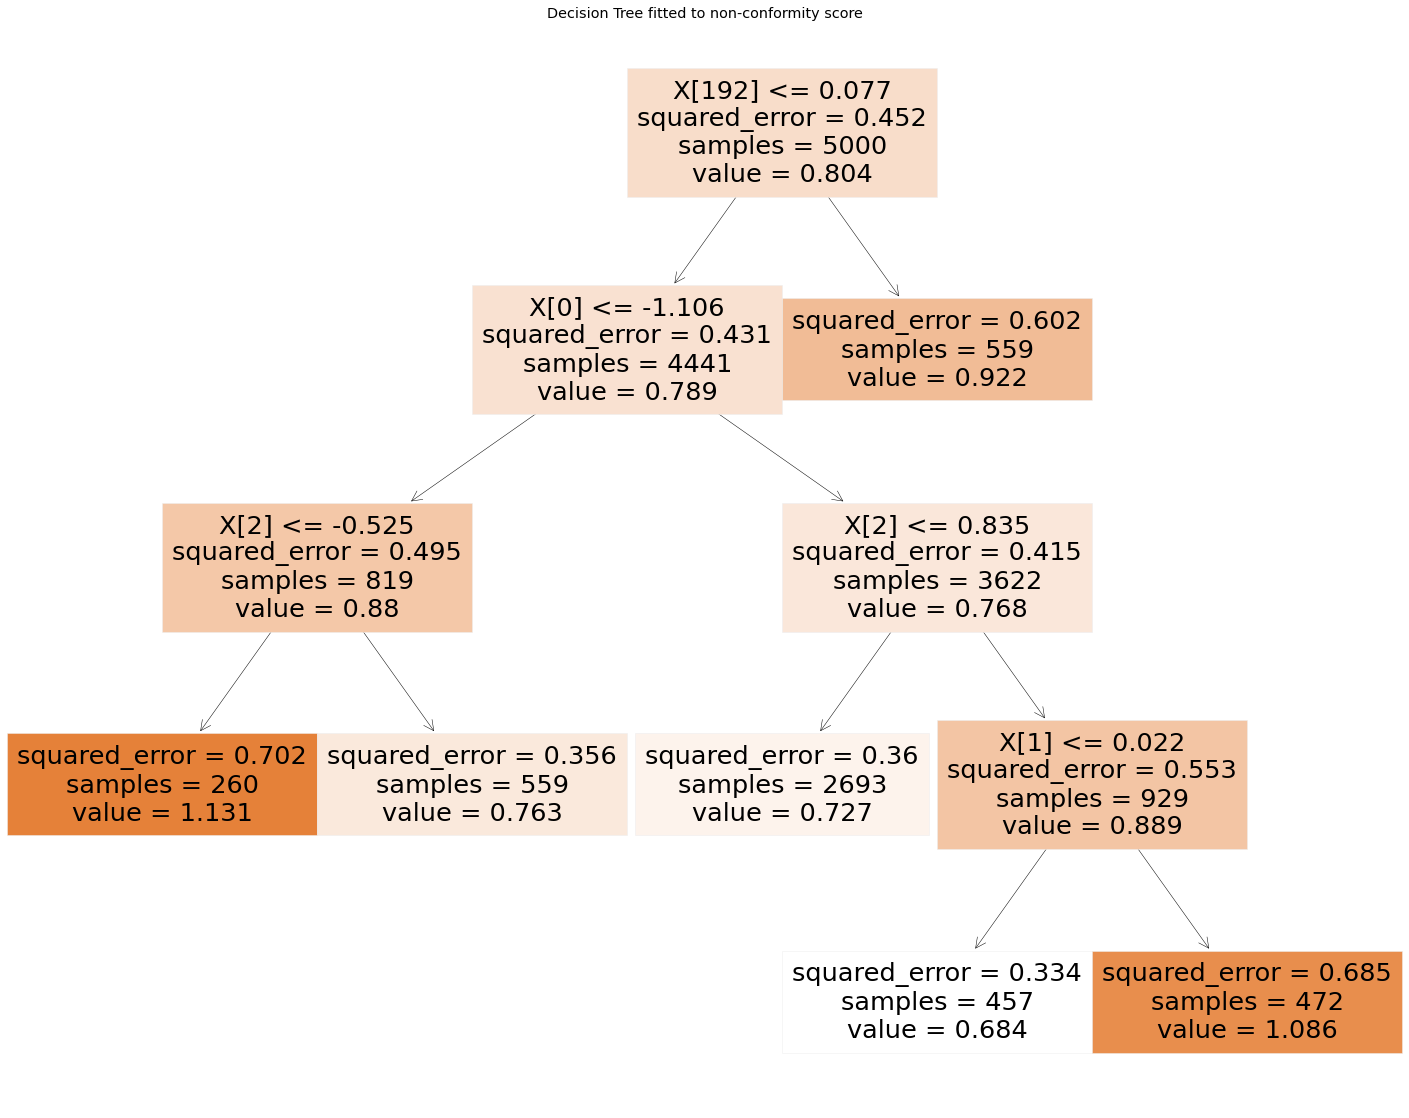

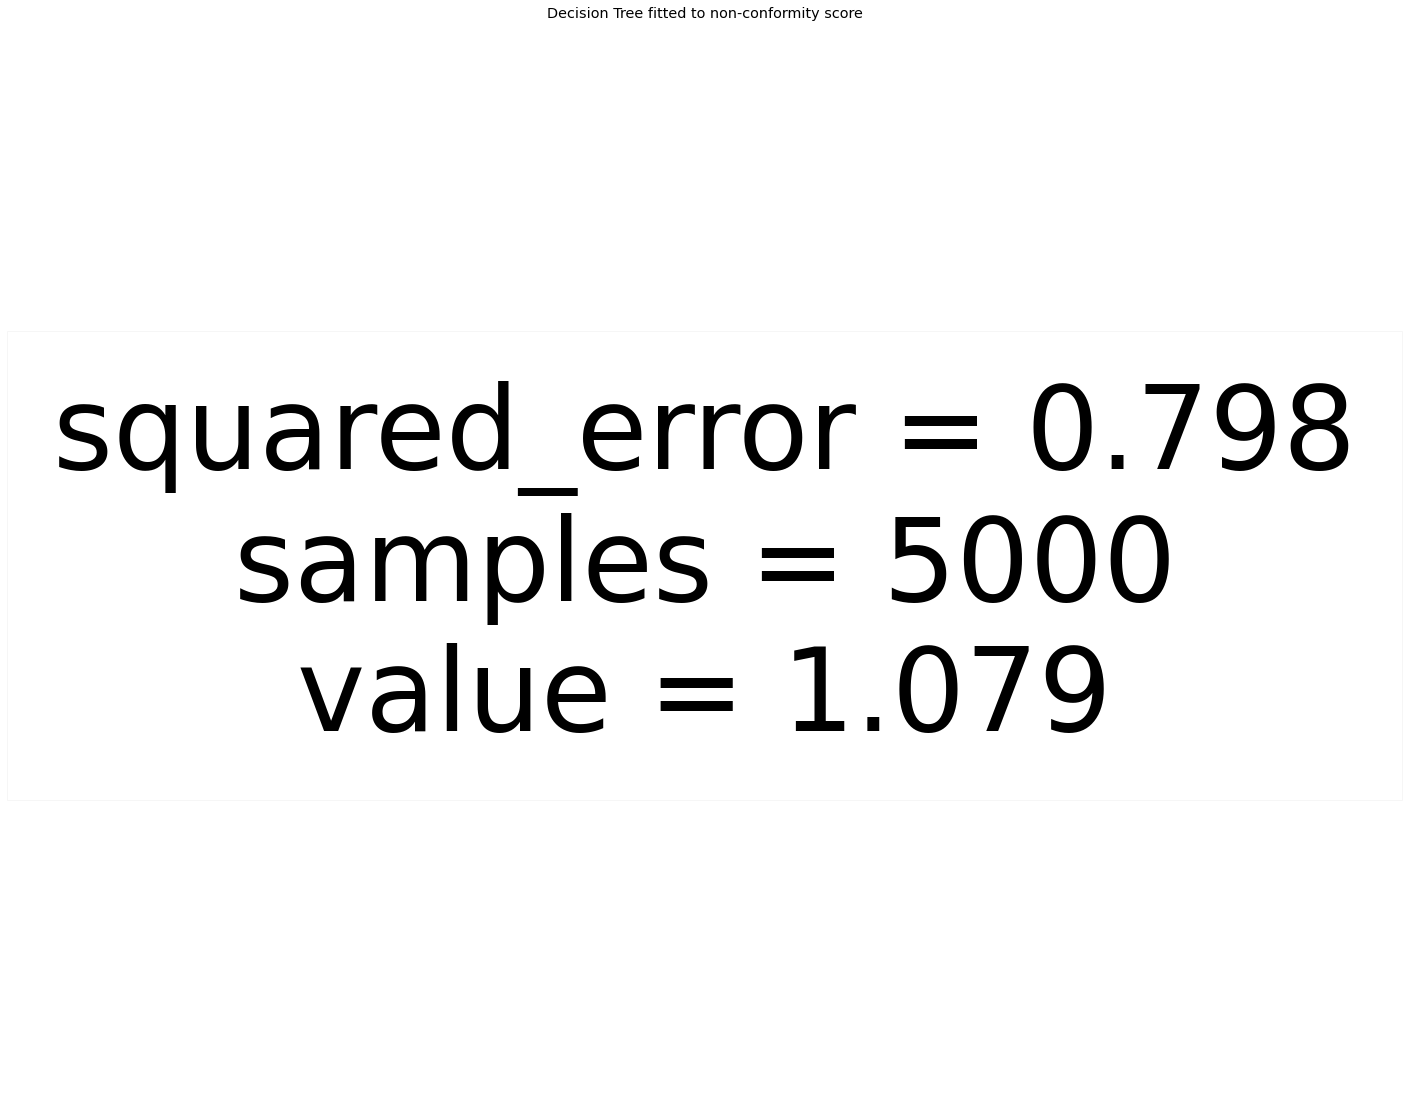

In [ ]:
non_corr_heteroc_metrics = testing_metrics_sim(base_model = KNeighborsRegressor, kind = "non_cor_heteroscedastic", hetero_value = 0.25, n_neighbors = 30, random_seed = 950,
                                               valid_test_size=0.5, nbins = 30, noise = False,  split_calib = True, m = 300, valid_split = False, valid_prune = True, 
                                               valid_min_sample = 150, min_samples_leaf = 150)

In [ ]:
non_corr_heteroc_metrics

,Methods,valid pred set,smis,max pred set,Average marginal coverage,Average interval length,Average interval length given coverage,Average distance,Median distance,Max distance
0,LOCART,0.05792,-4.453030,0.206667,0.8950,3.385603,3.386165,0.063983,0.061,0.255
1,Weighted LOCART,0.05032,-4.473529,0.125166,0.9002,3.477926,3.490283,0.061227,0.058,0.307
2,Regresion split,0.05616,-4.518353,0.169231,0.8932,3.391125,3.391125,0.068880,0.067,0.254
3,Weighted regression split,0.04760,-4.472771,0.120126,0.8984,3.447241,3.459245,0.061877,0.057,0.312
4,Mondrian regression split,0.05220,-4.522613,0.151366,0.8902,3.315002,3.328665,0.068344,0.065,0.278
